# Exploration of factors influencing students’ PISA scores in Philippines with Machine Learning approaches: Regression Models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats

from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_score


import xgboost as xgb
from xgboost.sklearn import XGBRegressor

import xgboost as xg 
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.linear_model import LinearRegression
# Feature Importance 
import shap
from sklearn.inspection import PartialDependenceDisplay

In [2]:
#Import main data file
pisa2018_philippines = pd.read_csv('datasets/pisa2018_philippines.csv')

In [3]:
pisa2018_philippines.head()

CNTRYID    CNTSCHID    CNTSTUID                      STRATUM  EFFORT1  \
0  Philippines  60800001.0  60800289.0  PHL - stratum 12: Region 11      7.0   
1  Philippines  60800001.0  60800533.0  PHL - stratum 12: Region 11      6.0   
2  Philippines  60800001.0  60800604.0  PHL - stratum 12: Region 11     10.0   
3  Philippines  60800001.0  60801150.0  PHL - stratum 12: Region 11      9.0   
4  Philippines  60800001.0  60801220.0  PHL - stratum 12: Region 11      5.0   

   EFFORT2                                              OCOD1  \
0      7.0                                          Housewife   
1      9.0                                Medical secretaries   
2     10.0                                            Missing   
3     10.0    Teaching professionals not elsewhere classified   
4      7.0  Vague(a good job, a quiet job, a well paid job...   

                                               OCOD2  \
0  Vague(a good job, a quiet job, a well paid job...   
1                           Construction supervisors   
2                                            Missing   
3  Professional services managers not elsewhere c...   
4                               Electrical engineers   

                                               OCOD3  GRADE  ...  \
0            Aircraft engine mechanics and repairers    1.0  ...   
1                   Specialist medical practitioners    0.0  ...   
2                                    Police officers    0.0  ...   
3  Aircraft pilots and related associate professi...    1.0  ...   
4  Vague(a good job, a quiet job, a well paid job...    0.0  ...   

                    UNIT WVARSTRR    SENWT             VER_DAT test GENDER  \
0  final variance unit 3      7.0  0.80000    30APR19:12:06:04  NaN      0   
1  final variance unit 3      7.0  0.84215    30APR19:12:06:04  NaN      0   
2  final variance unit 3      7.0  0.84215    30APR19:12:06:04  NaN      0   
3  final variance unit 3      7.0  0.80000    30APR19:12:06:04  NaN      0   
4  final variance unit 3      7.0  0.84215    30APR19:12:06:04  NaN      0   

       MATH   SCIENCE      READ  TOTALSCORE  
0  382.5703  375.1763  365.3463  374.364300  
1  430.8153  478.0337  453.7995  454.216167  
2  329.4409  341.1251  339.1177  336.561233  
3  407.1276  389.5056  404.1598  400.264333  
4  364.8726  385.4762  337.6048  362.651200  

[5 rows x 129 columns]

In [4]:
#Check simple statistics
pisa2018_philippines.describe().round(2).T

count         mean      std          min          25%  \
CNTSCHID    7233.0  60800094.70    54.62  60800001.00  60800047.00   
CNTSTUID    7233.0  60803800.87  2198.18  60800001.00  60801900.00   
EFFORT1     4894.0         8.80     1.58         1.00         8.00   
EFFORT2     4778.0         8.91     1.63         1.00         8.00   
GRADE       7233.0         0.11     0.79        -2.00         0.00   
...            ...          ...      ...          ...          ...   
GENDER      7233.0         0.53     0.50         0.00         0.00   
MATH        7233.0       351.86    71.80       109.13       301.96   
SCIENCE     7233.0       356.13    69.59       167.43       306.72   
READ        7233.0       338.82    76.24       133.68       281.53   
TOTALSCORE  7233.0       348.94    70.21       142.59       298.20   

                    50%          75%          max  
CNTSCHID    60800095.00  60800142.00  60800188.00  
CNTSTUID    60803797.00  60805706.00  60807604.00  
EFFORT1            9.00        10.00        10.00  
EFFORT2           10.00        10.00        10.00  
GRADE              0.00         1.00         3.00  
...                 ...          ...          ...  
GENDER             1.00         1.00         1.00  
MATH             346.90       397.78       628.82  
SCIENCE          344.69       395.28       639.20  
READ             324.68       383.79       655.32  
TOTALSCORE       337.30       390.61       628.71  

[100 rows x 8 columns]

In [5]:
pisa2018_philippines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7233 entries, 0 to 7232
Columns: 129 entries, CNTRYID to TOTALSCORE
dtypes: float64(99), int64(1), object(29)
memory usage: 7.1+ MB


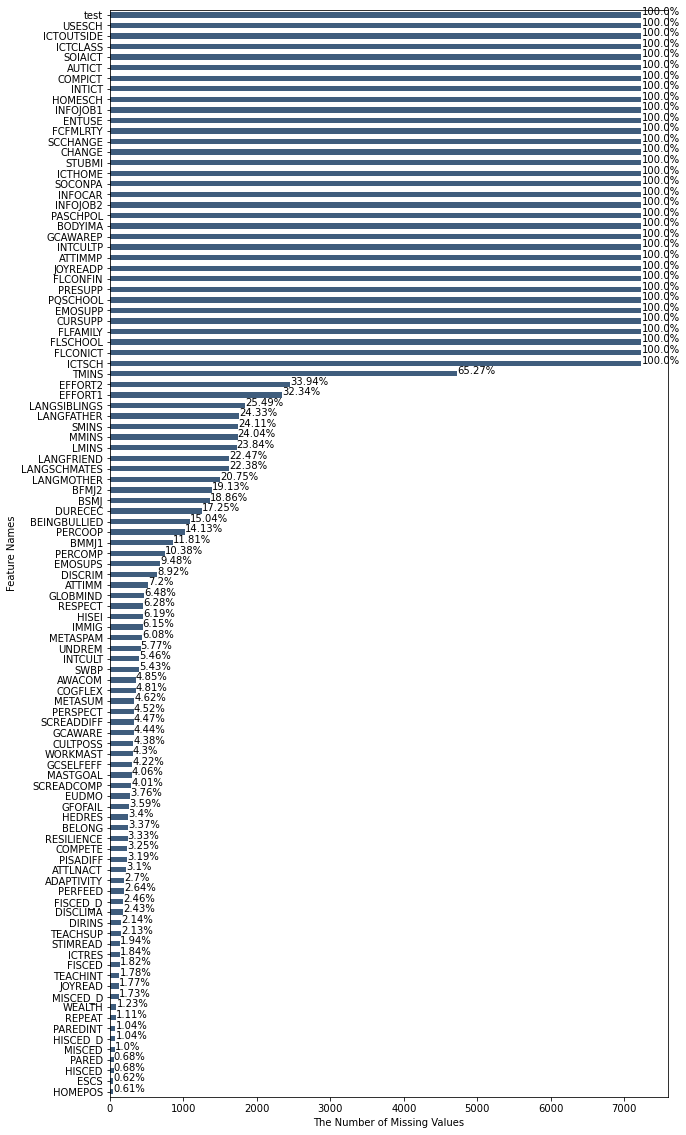

In [6]:
#Checking percentage of null values

Nan = pisa2018_philippines.isnull().sum()[pisa2018_philippines.isnull().sum()>0]

Nan.sort_values().plot(kind='barh', figsize=(10, 20), color = "#3F5D7D");

for y, x in enumerate(Nan.sort_values()):
    
    plt.annotate(str(round(x/pisa2018_philippines.shape[0]*100,2))+'%', xy=(x, y), size=10)
    
plt.xlabel('The Number of Missing Values')

plt.ylabel('Feature Names');

In [7]:
#Drop column with NAN more than 10%
NanPer = len(pisa2018_philippines) *.90
pisa2018_philippines = pisa2018_philippines.dropna(thresh=NanPer, axis=1)

In [8]:
#Split data into train and test
train_philippines , test_philippines  = train_test_split(pisa2018_philippines, test_size=0.2, random_state=42)

print(f"No. of training examples: {train_philippines.shape[0]}")
print(f"No. of testing examples: {test_philippines.shape[0]}")

No. of training examples: 5786
No. of testing examples: 1447


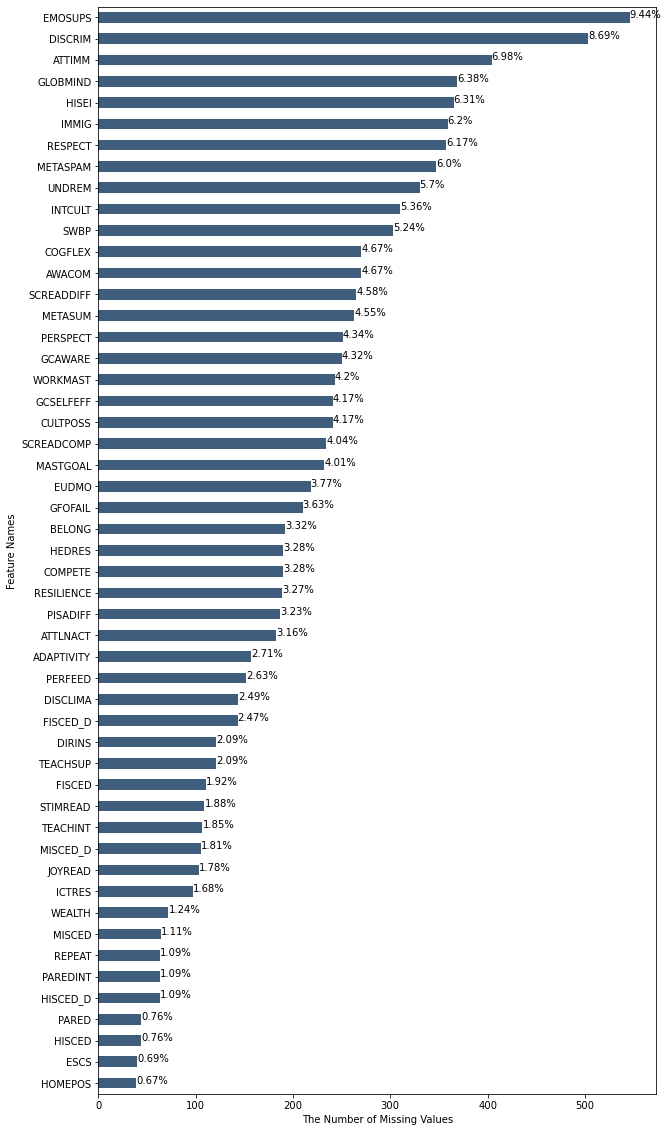

In [9]:
#Checking percentage of null values

Nan = train_philippines.isnull().sum()[train_philippines.isnull().sum()>0]

Nan.sort_values().plot(kind='barh', figsize=(10, 20), color = "#3F5D7D");

for y, x in enumerate(Nan.sort_values()):
    
    plt.annotate(str(round(x/train_philippines.shape[0]*100,2))+'%', xy=(x, y), size=10)
    
plt.xlabel('The Number of Missing Values')

plt.ylabel('Feature Names');

In [10]:
#change data type
train_philippines['GENDER'] = train_philippines['GENDER'].astype('object')
test_philippines['GENDER'] = test_philippines['GENDER'].astype('object')

In [11]:
#Fill NAN values with train columns' median
numvar = train_philippines.dtypes !="object"
numeric_features = list(numvar[numvar].index)
for col in numeric_features:
    train_philippines[col].fillna(train_philippines[col].median(), inplace=True)
    test_philippines[col].fillna(train_philippines[col].median(), inplace=True)

In [12]:
#Fill NAN values with train columns' mode
obvar = train_philippines.dtypes =="object"
categorical_features = list(obvar[obvar].index)
for col in categorical_features:
    train_philippines[col].fillna(train_philippines[col].mode()[0], inplace=True)
    test_philippines[col].fillna(train_philippines[col].mode()[0], inplace=True)

In [13]:
train_philippines.isnull().sum().sum(),test_philippines.isnull().sum().sum()

(0, 0)

In [14]:
list(train_philippines.columns)

['CNTRYID',
 'CNTSCHID',
 'CNTSTUID',
 'STRATUM',
 'OCOD1',
 'OCOD2',
 'OCOD3',
 'GRADE',
 'AGE',
 'PROGN',
 'COBN_S',
 'COBN_M',
 'COBN_F',
 'LANGN',
 'ISCEDL',
 'ISCEDD',
 'ISCEDO',
 'MISCED',
 'FISCED',
 'HISCED',
 'PARED',
 'MISCED_D',
 'FISCED_D',
 'HISCED_D',
 'PAREDINT',
 'HISEI',
 'IMMIG',
 'REPEAT',
 'ESCS',
 'UNDREM',
 'METASUM',
 'METASPAM',
 'HOMEPOS',
 'CULTPOSS',
 'HEDRES',
 'WEALTH',
 'ICTRES',
 'DISCLIMA',
 'TEACHSUP',
 'DIRINS',
 'PERFEED',
 'EMOSUPS',
 'STIMREAD',
 'ADAPTIVITY',
 'TEACHINT',
 'JOYREAD',
 'SCREADCOMP',
 'SCREADDIFF',
 'PISADIFF',
 'ATTLNACT',
 'COMPETE',
 'WORKMAST',
 'GFOFAIL',
 'EUDMO',
 'SWBP',
 'RESILIENCE',
 'MASTGOAL',
 'GCSELFEFF',
 'GCAWARE',
 'ATTIMM',
 'INTCULT',
 'PERSPECT',
 'COGFLEX',
 'RESPECT',
 'AWACOM',
 'GLOBMIND',
 'DISCRIM',
 'BELONG',
 'UNIT',
 'WVARSTRR',
 'SENWT',
 'VER_DAT',
 'GENDER',
 'MATH',
 'SCIENCE',
 'READ',
 'TOTALSCORE']

In [15]:
#Set CNTSTUID as index
train_philippines.set_index('CNTSTUID', inplace=True)
test_philippines.set_index('CNTSTUID', inplace=True)

In [16]:
train_philippines.drop(columns=['CNTRYID','CNTSCHID','STRATUM','OCOD1','OCOD2','OCOD3','PROGN','COBN_S',
                                'COBN_M','COBN_F','LANGN','UNIT', 'VER_DAT', 'SENWT'], axis =1, inplace = True)
test_philippines.drop(columns=['CNTRYID','CNTSCHID','STRATUM','OCOD1','OCOD2','OCOD3','PROGN','COBN_S',
                                'COBN_M','COBN_F','LANGN','UNIT', 'VER_DAT', 'SENWT'], axis =1, inplace = True)

In [17]:
train_philippines.shape, test_philippines.shape

((5786, 62), (1447, 62))

## Exploring numerical variables

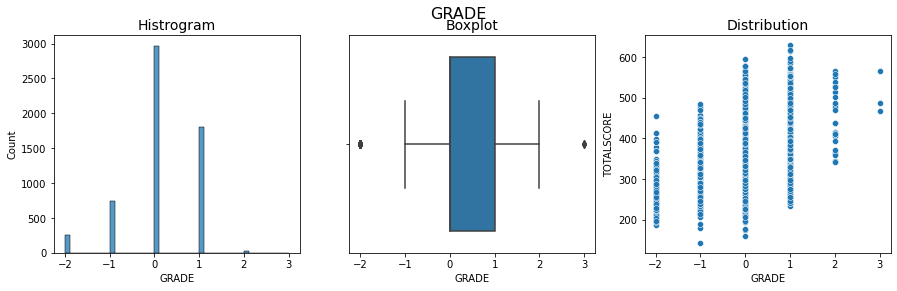

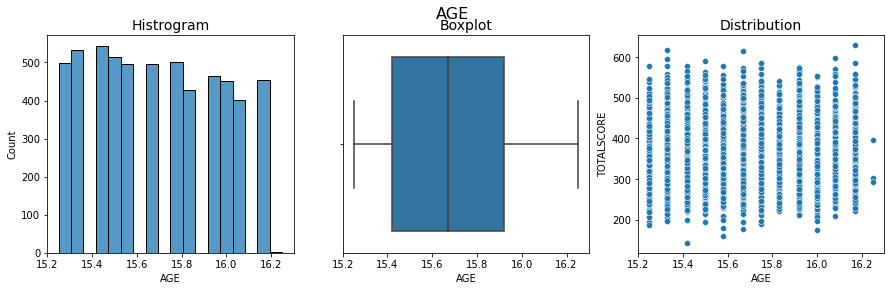

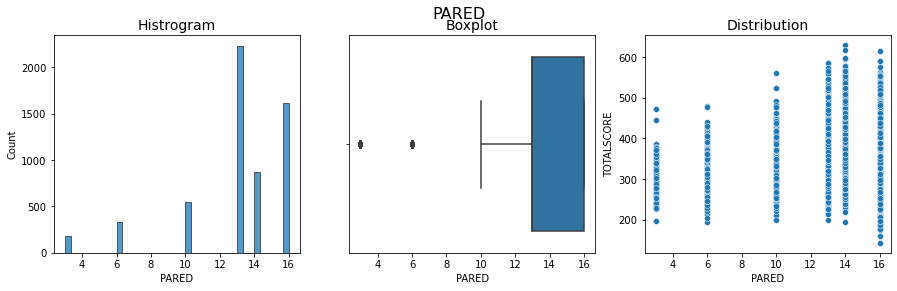

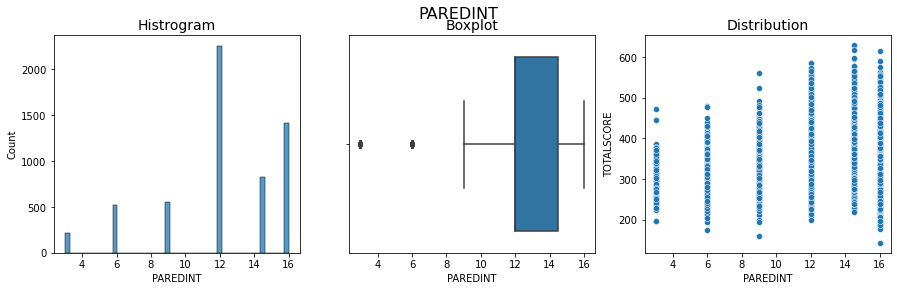

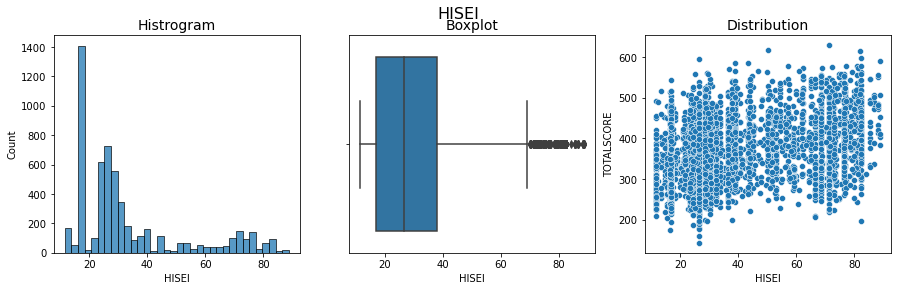

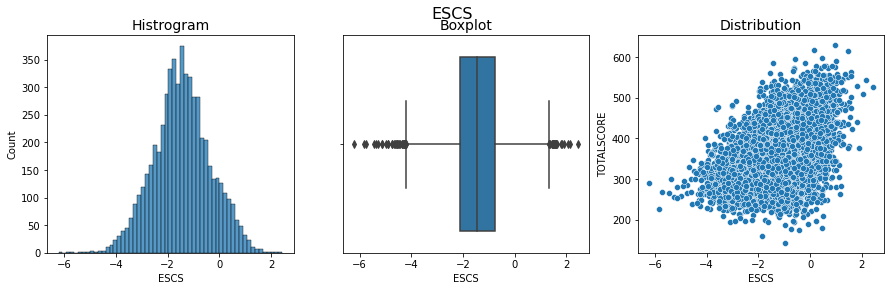

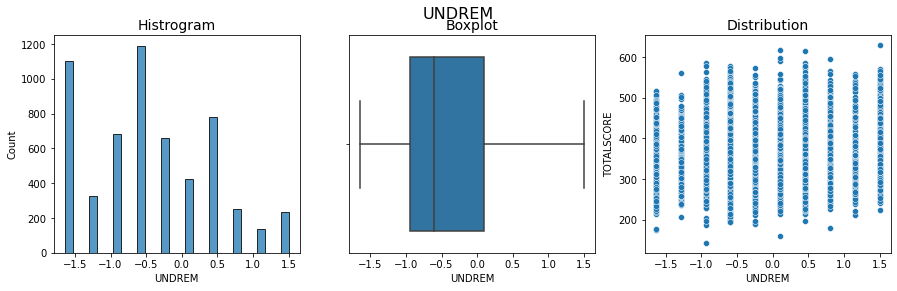

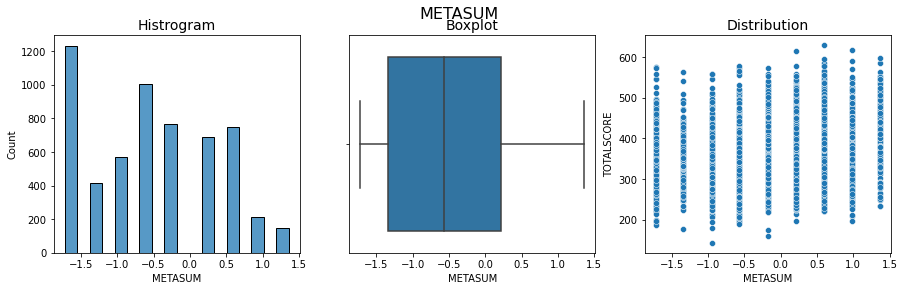

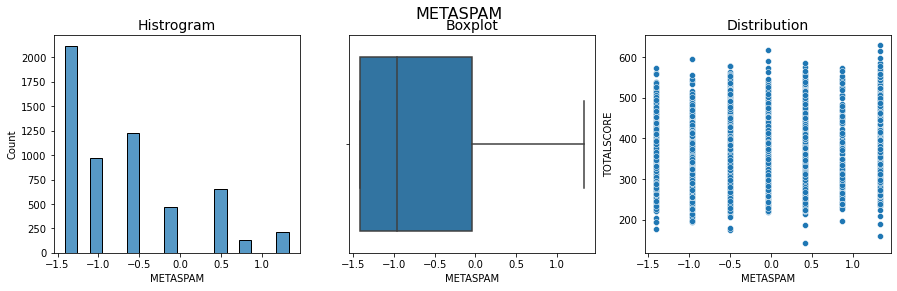

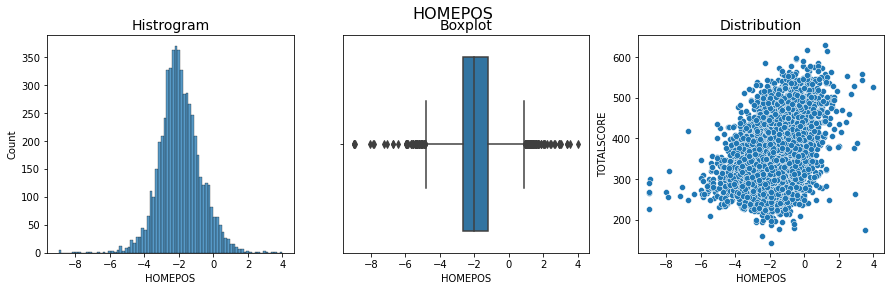

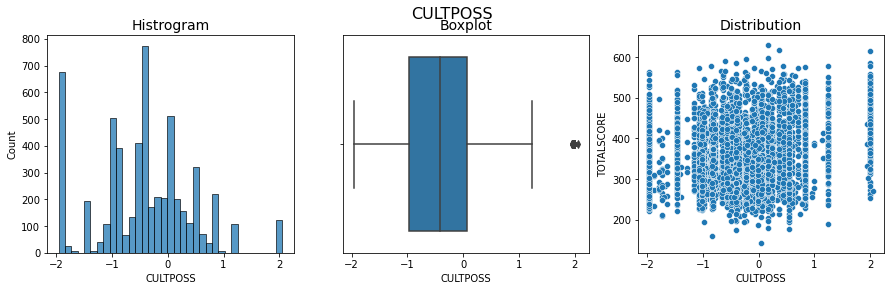

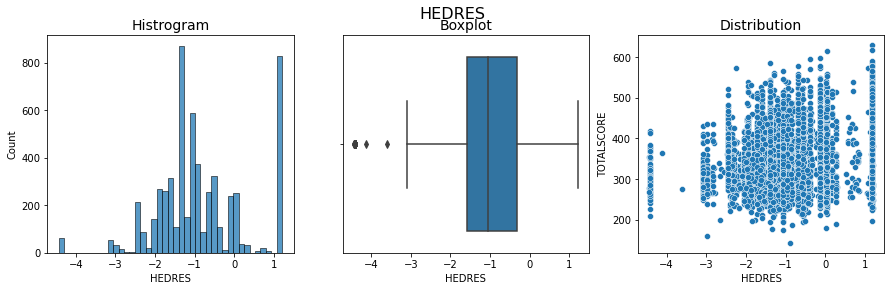

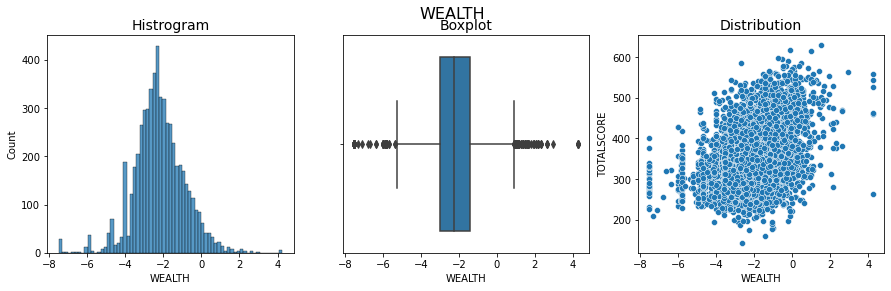

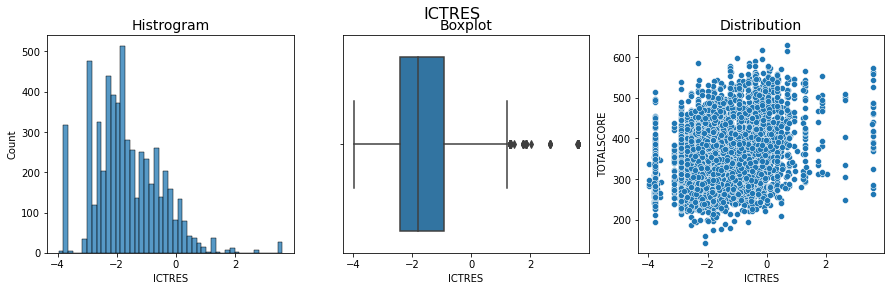

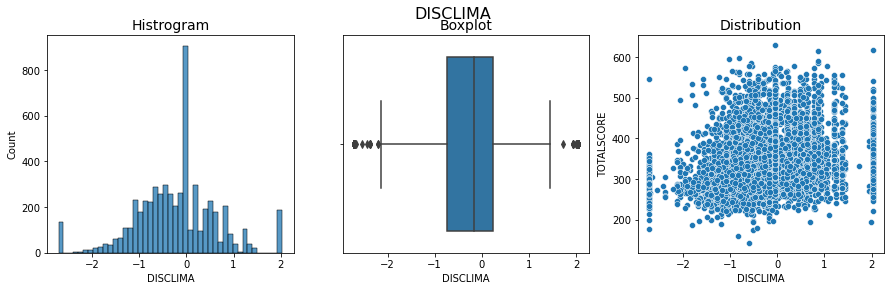

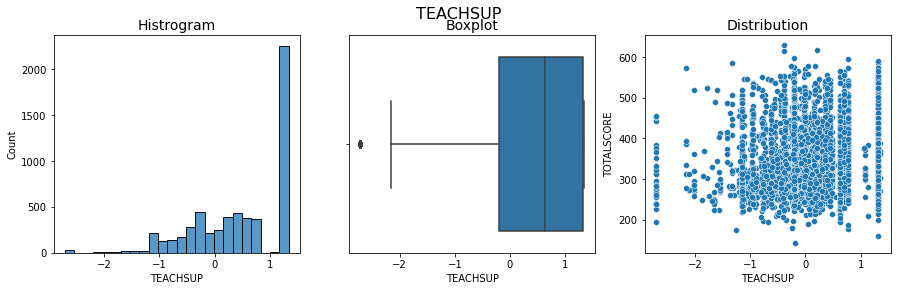

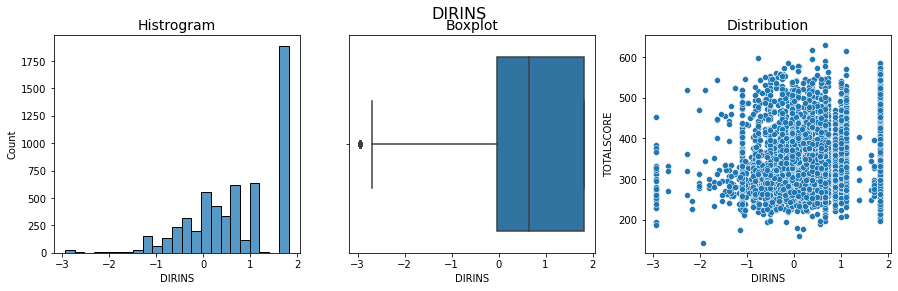

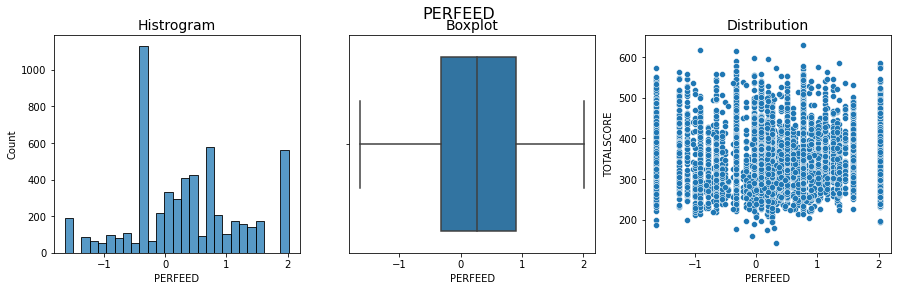

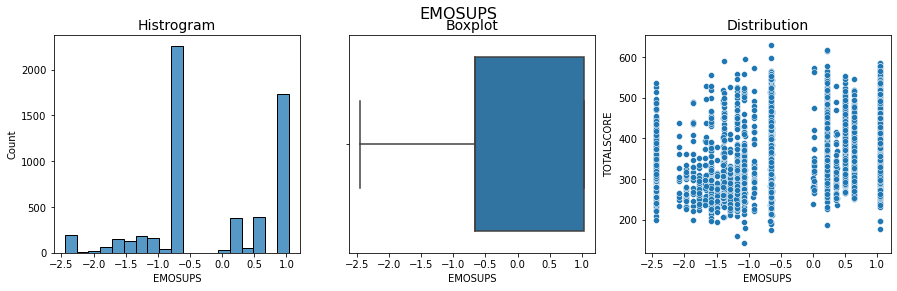

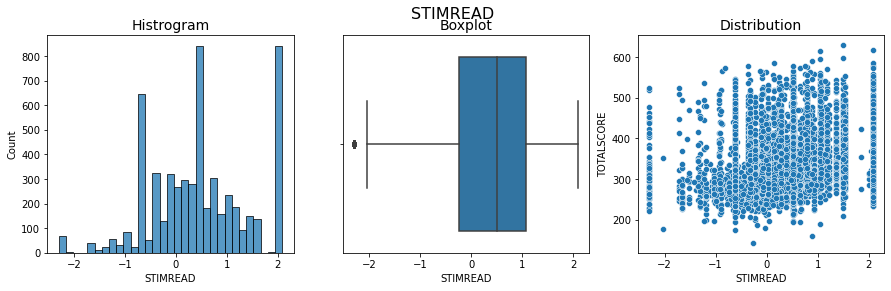

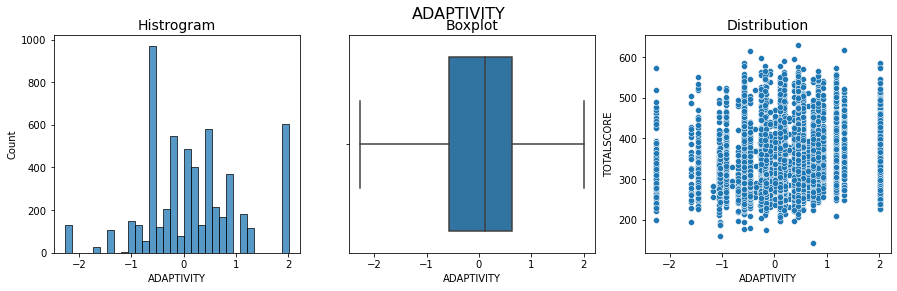

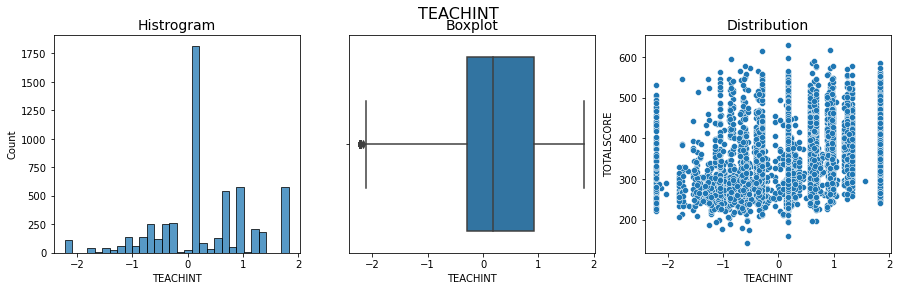

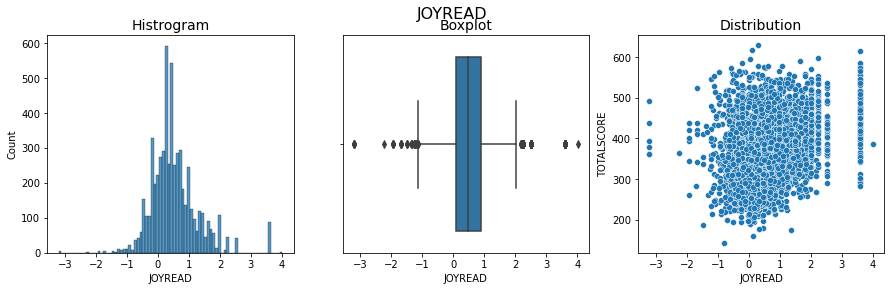

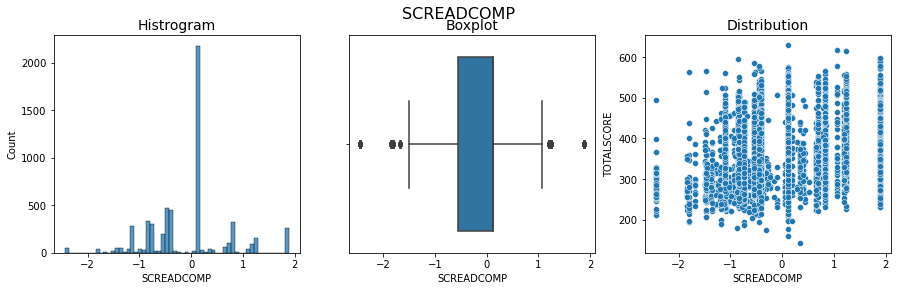

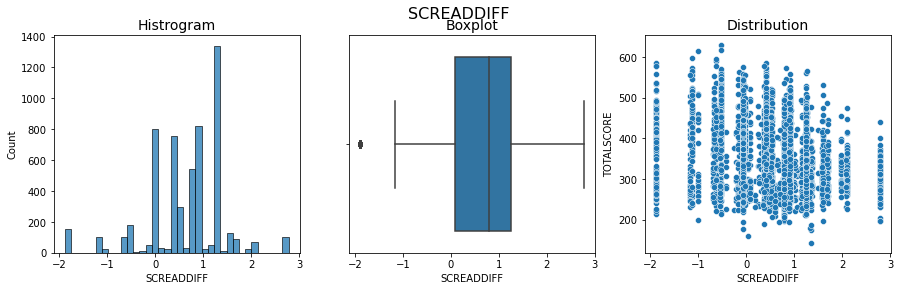

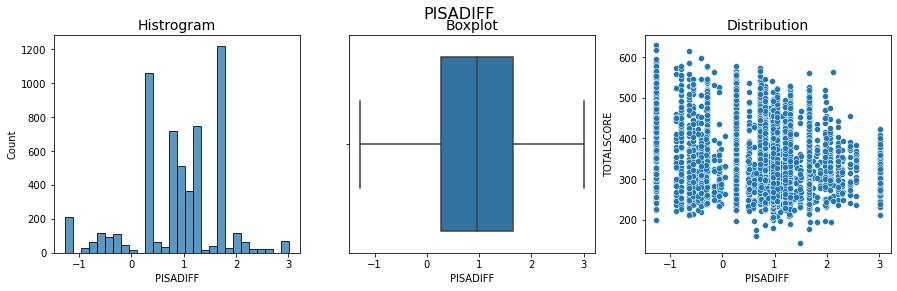

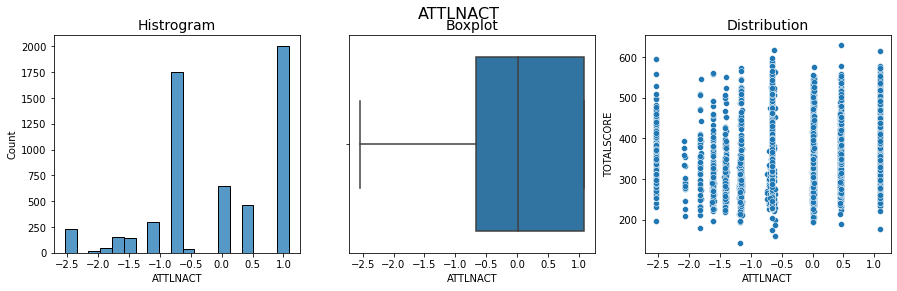

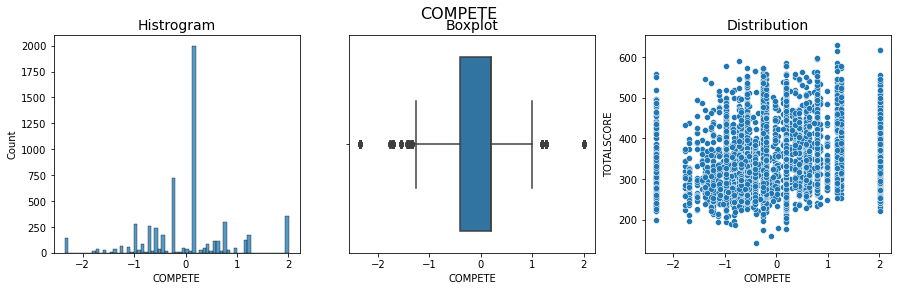

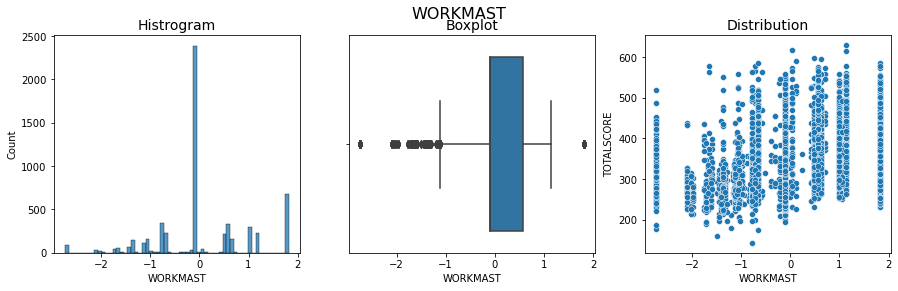

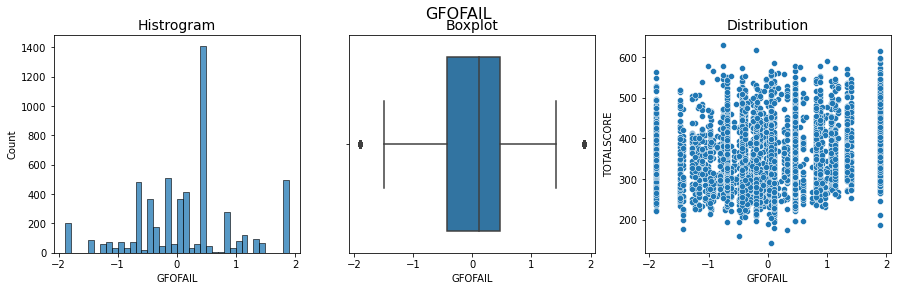

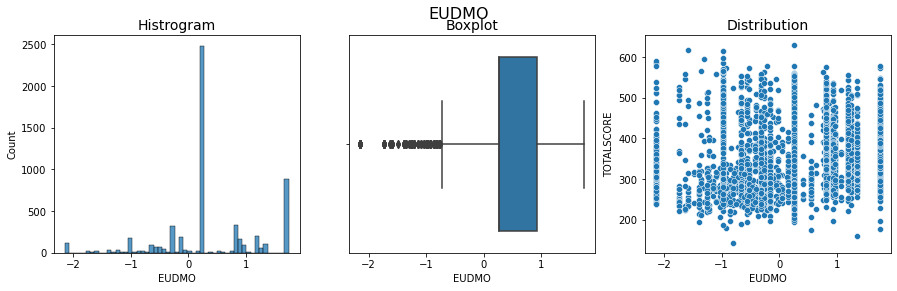

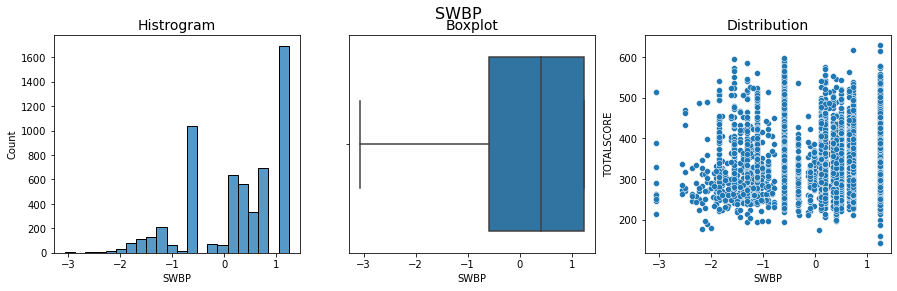

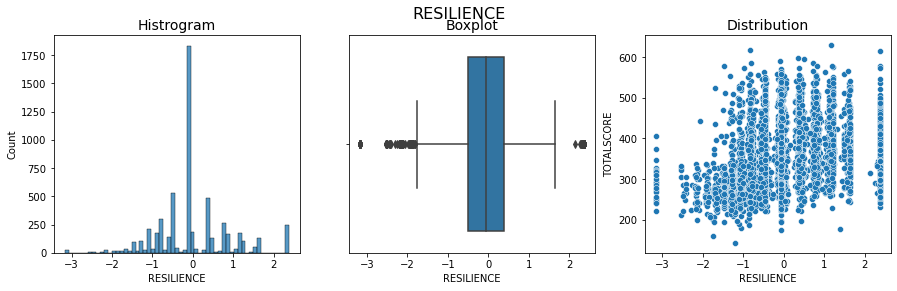

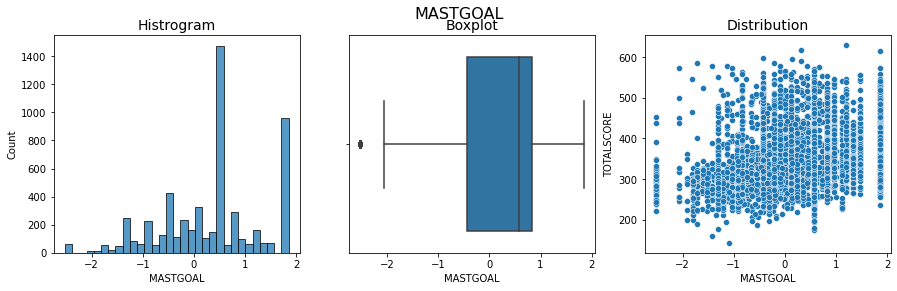

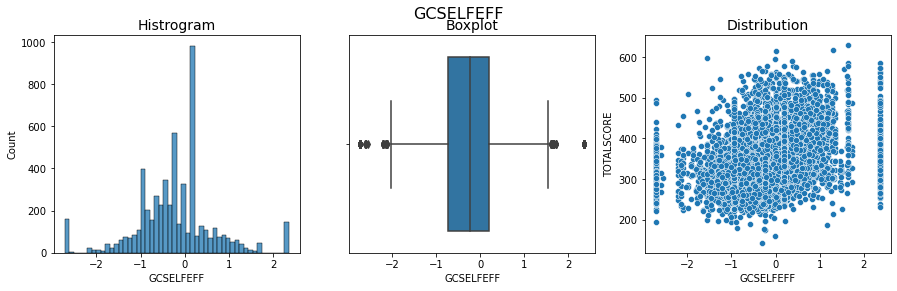

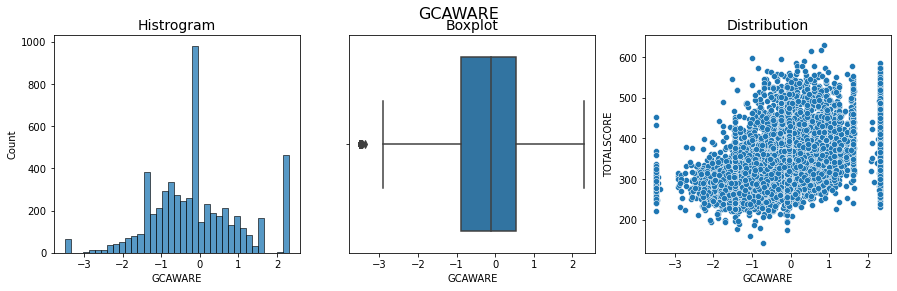

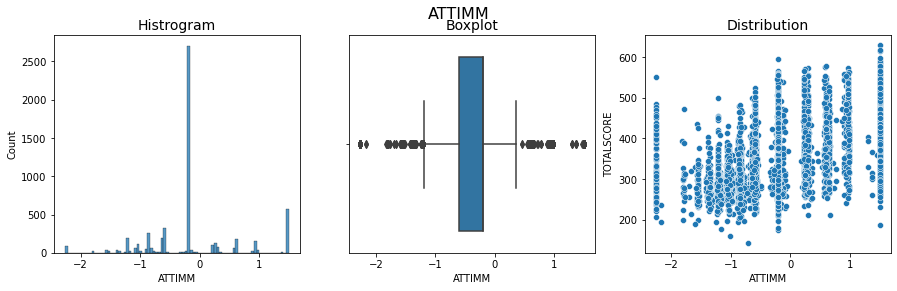

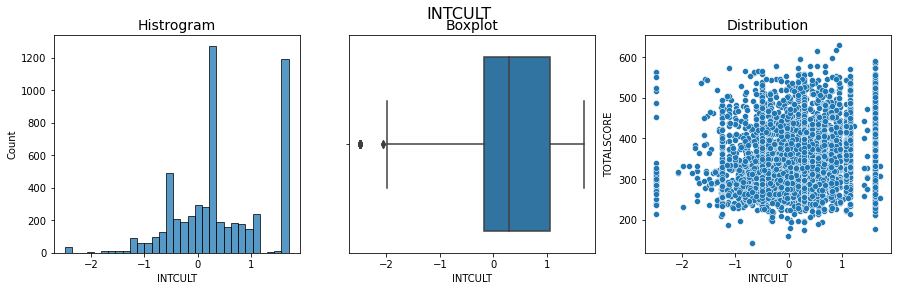

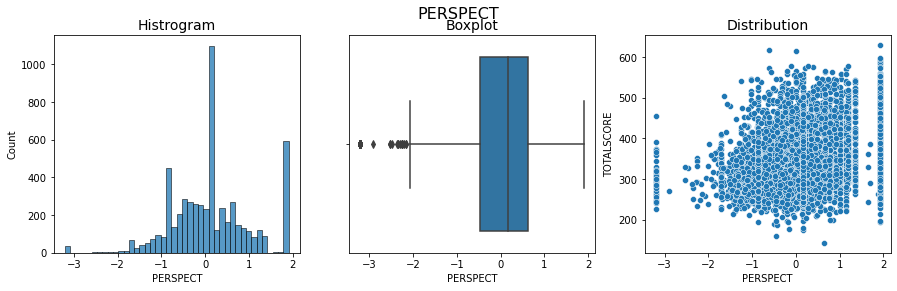

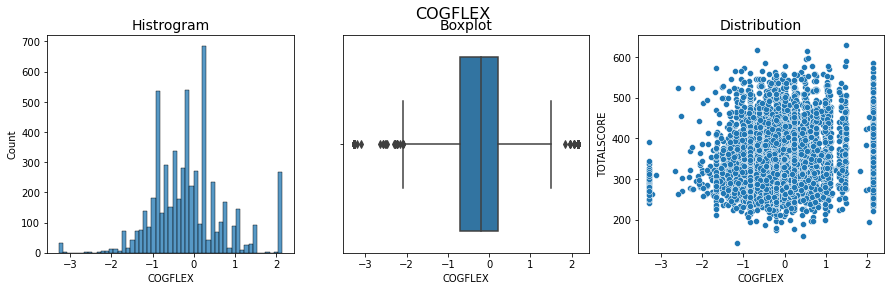

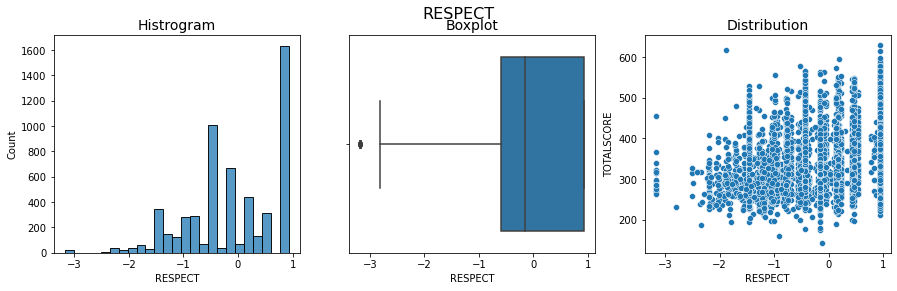

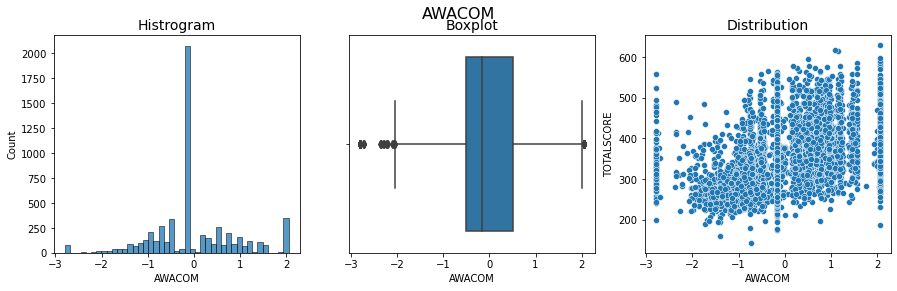

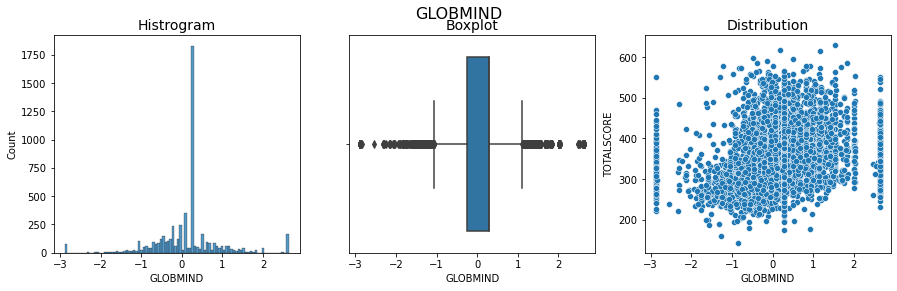

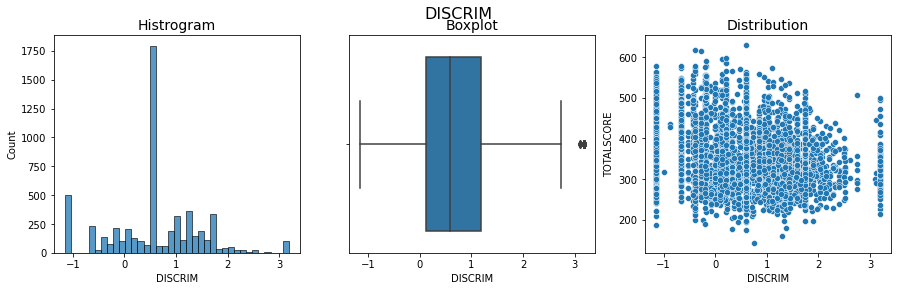

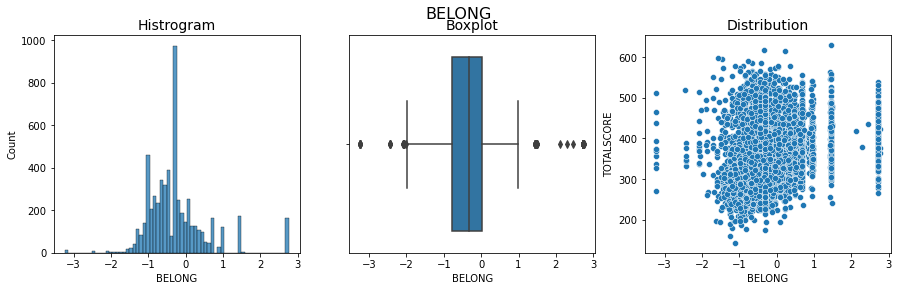

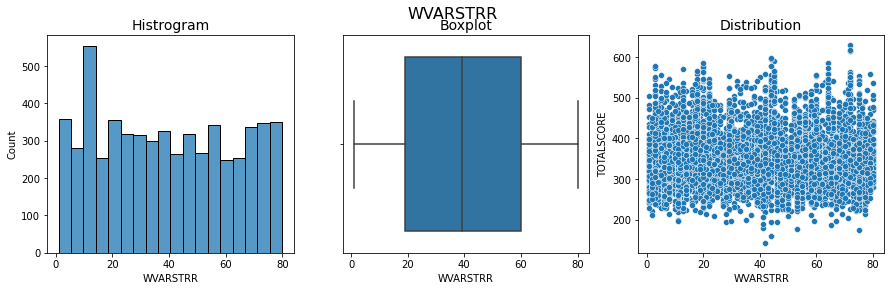

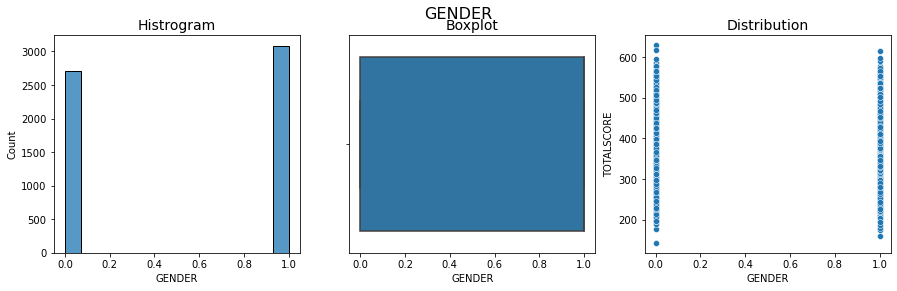

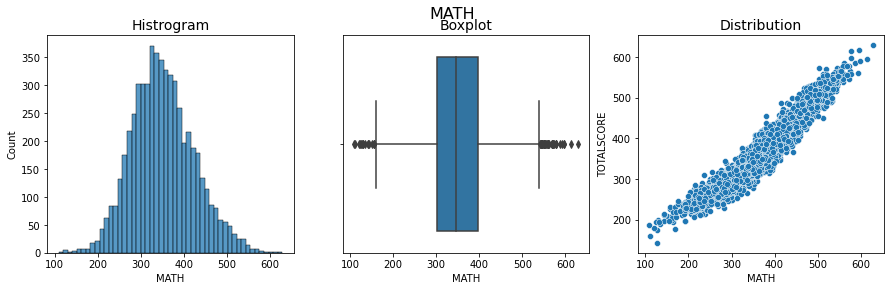

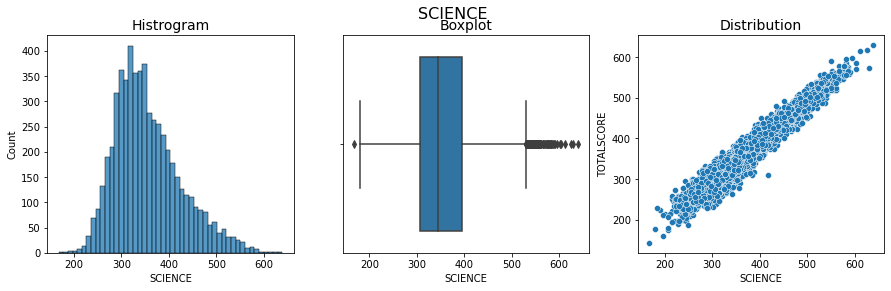

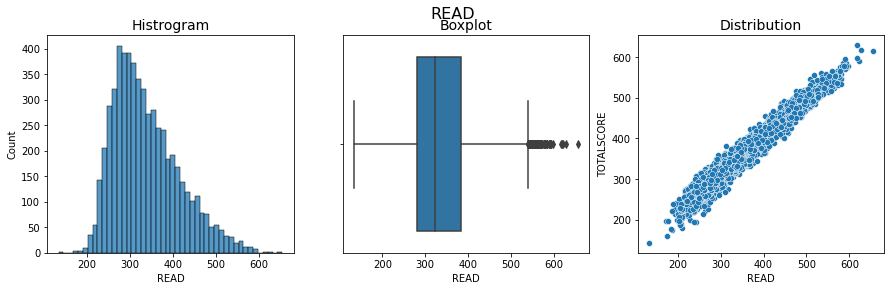

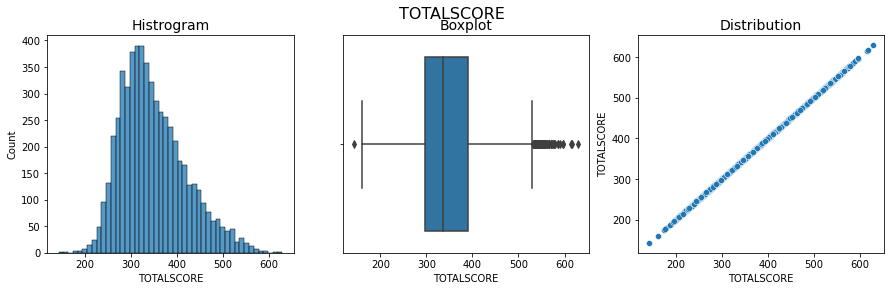

In [18]:
#Create Histrogram plot, Boxplot and Distribution plot of numerical features
numvar = train_philippines.dtypes !="object"
numeric_features = list(numvar[numvar].index)
for col in numeric_features:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
    ax = ax.ravel() 
    fig.suptitle(f"{col}\n", fontsize=16)
    ax[0].set_title(f'Histrogram', fontsize =14)
    sns.histplot(train_philippines[col], ax=ax[0])
    ax[1].set_title(f'Boxplot', fontsize =14)
    sns.boxplot(x=train_philippines[col], ax=ax[1])
    ax[2].set_title(f'Distribution', fontsize =14)
    sns.scatterplot(x = train_philippines[col], y= train_philippines['TOTALSCORE'],ax=ax[2])
    plt.show()

In [19]:
#remove extreme outliers
train_philippines = train_philippines[(train_philippines['PARED'] >4)]
train_philippines = train_philippines[(train_philippines['PAREDINT'] >4)]
train_philippines = train_philippines[(train_philippines['ESCS'] >= -3)]
train_philippines = train_philippines[(train_philippines['HOMEPOS'] > -5)]
train_philippines = train_philippines[(train_philippines['HOMEPOS'] < 4)]
train_philippines = train_philippines[(train_philippines['HEDRES'] > -4)]
train_philippines = train_philippines[(train_philippines['WEALTH'] > -4)]
train_philippines = train_philippines[(train_philippines['ICTRES'] > -4)]
train_philippines = train_philippines[(train_philippines['WORKMAST'] > -3)]

In [20]:
train_philippines.shape, test_philippines.shape

((4999, 62), (1447, 62))

## Exploring categorical features

In [21]:
# Create a function to plot boxplot for categorical features

def subplot_boxplot(dataframe, list_of_columns):
    
    nrows = int(np.ceil(len(list_of_columns)/2)) 
    
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(15,5*nrows)) 
    
    ax = ax.ravel() 
    
    if len(list_of_columns) %2 !=0:
        
        ax[len(list_of_columns)].set_visible(False)
        
    for i, column in enumerate(list_of_columns):
        
        names = train_philippines.groupby(column).mean()['TOTALSCORE'].sort_values().index
        
        sns.boxplot(x = dataframe[column],y = dataframe['TOTALSCORE'],order = names, ax = ax[i], color="#99d6ff") 
        
        ax[i].set_title(f'TOTALSCORE  vs {column}', fontsize =16)
        
        ax[i].set_ylabel('Values',fontsize=15)
        
        ax[i].set_xlabel(column,fontsize=15) 
        
        ax[i].set_xticklabels(names,rotation=40) 
        
    plt.tight_layout()

In [22]:
#Create boxplot
obvar = train_philippines.dtypes =="object"
categorical_features = list(obvar[obvar].index) 

In [23]:
categorical_features 

['ISCEDL',
 'ISCEDD',
 'ISCEDO',
 'MISCED',
 'FISCED',
 'HISCED',
 'MISCED_D',
 'FISCED_D',
 'HISCED_D',
 'IMMIG',
 'REPEAT']

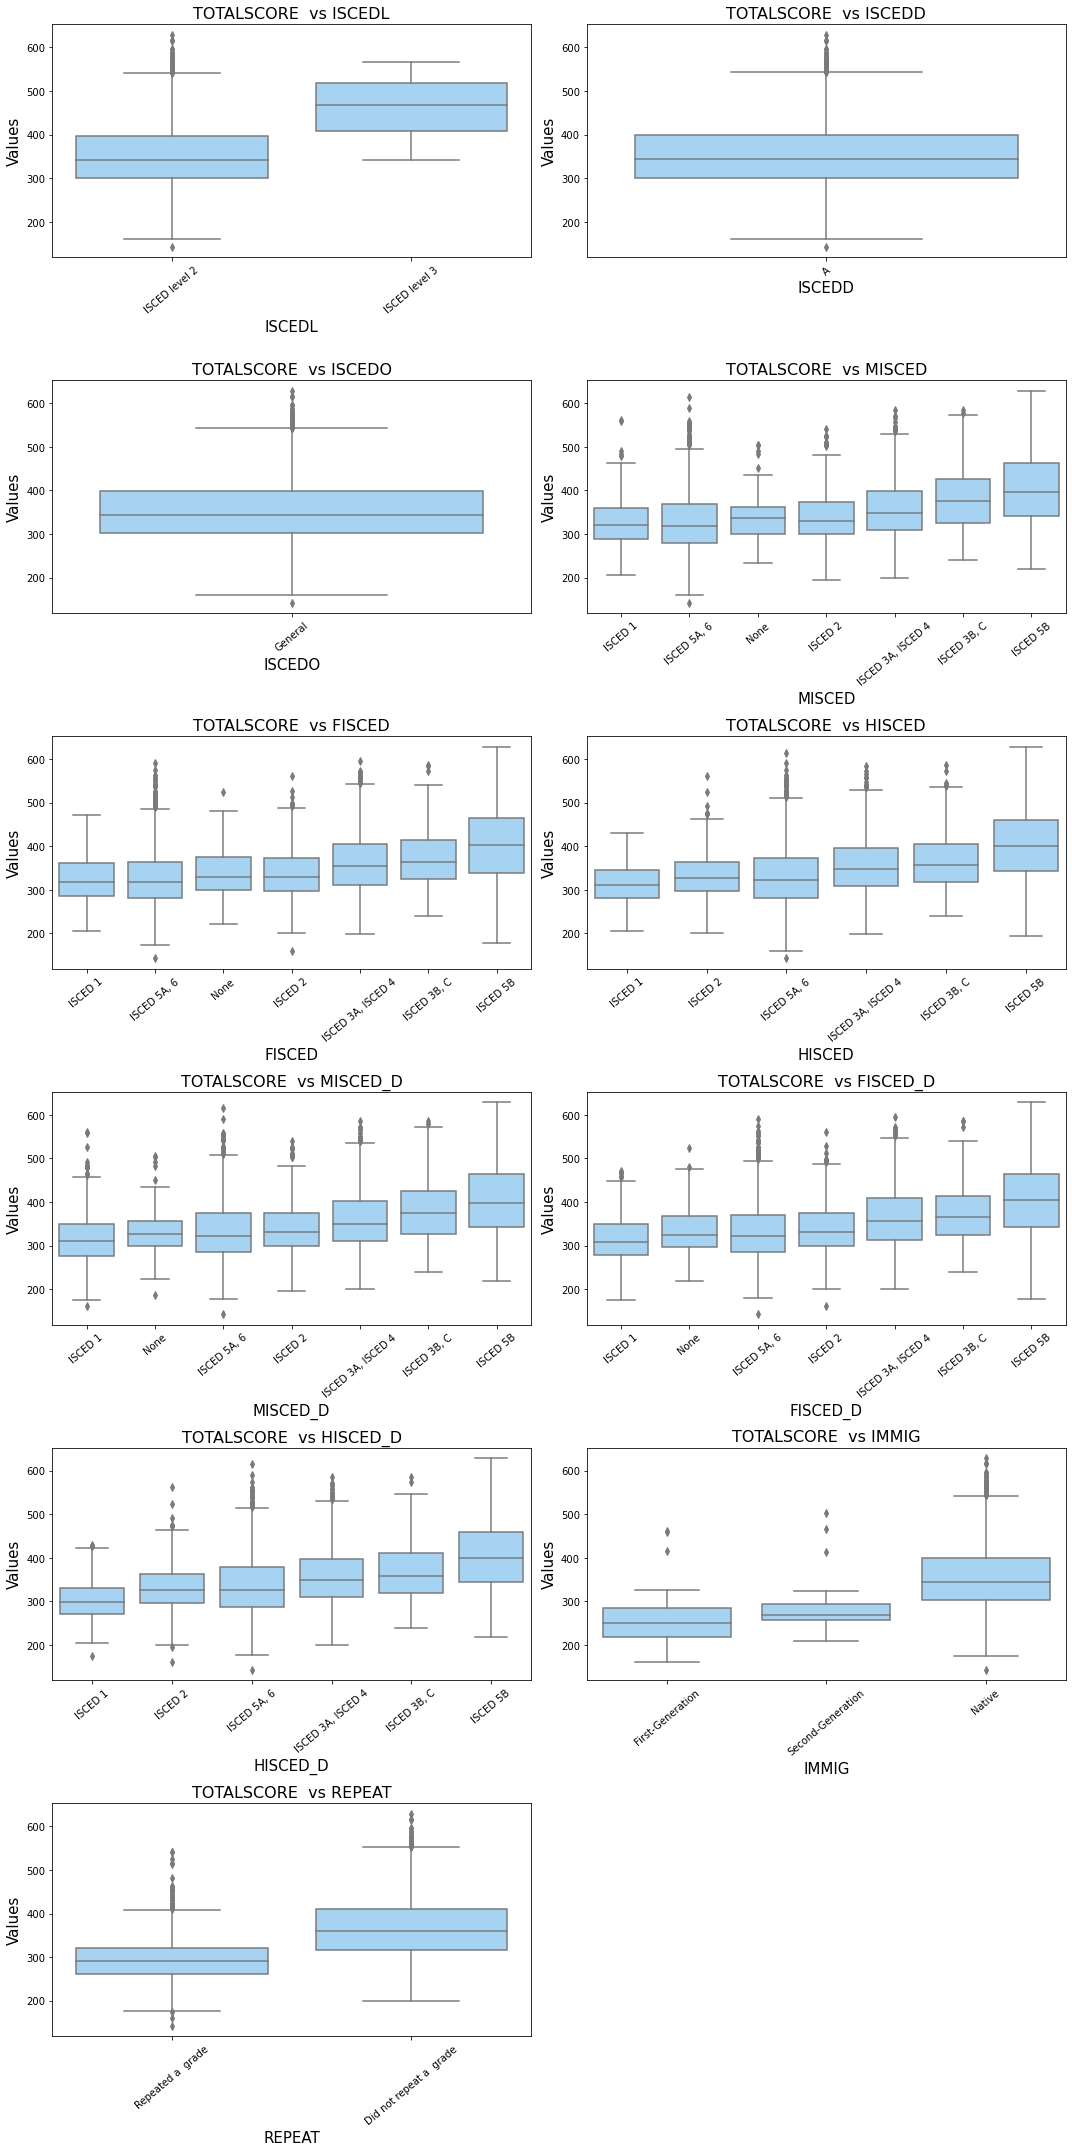

In [24]:
subplot_boxplot(train_philippines, categorical_features)

According to the boxplots, some features has duplicated information. Moreover, the subgroup of 'MISCED', 'FISCED', 'HISCED' have similar means except 'ISCED 5A, 6', Thus, all subgroup will be combined into one group to reduce number of dummy codes. 

In [25]:
#Drop duplicated features 
train_philippines.drop(columns=['MISCED_D', 'FISCED_D', 'HISCED_D', 'ISCEDD','ISCEDO'], axis =1, inplace = True)
test_philippines.drop(columns=['MISCED_D', 'FISCED_D', 'HISCED_D', 'ISCEDD','ISCEDO'], axis =1, inplace = True)

In [26]:
#Grouping values of categorical columns to reduce number of categories. 
train_philippines['Is_MISCED_5B'] = np.where(train_philippines['MISCED'] == 'ISCED 5B', 1, 0)
train_philippines['Is_FISCED_5B'] = np.where(train_philippines['FISCED'] == 'ISCED 5B', 1, 0)
train_philippines['Is_HISCED_5B'] = np.where(train_philippines['HISCED'] == 'ISCED 5B', 1, 0)

In [27]:
#Grouping values of categorical columns to reduce number of categories. 
test_philippines['Is_MISCED_5B'] = np.where(test_philippines['MISCED'] == 'ISCED 5B', 1, 0)
test_philippines['Is_FISCED_5B'] = np.where(test_philippines['FISCED'] == 'ISCED 5B', 1, 0)
test_philippines['Is_HISCED_5B'] = np.where(test_philippines['HISCED'] == 'ISCED 5B', 1, 0)

In [28]:
#Drop original columns
train_philippines.drop(columns= ['MISCED', 'FISCED', 'HISCED'], axis =1, inplace =True)
test_philippines.drop(columns= ['MISCED', 'FISCED', 'HISCED'], axis =1, inplace =True)

## Explore relationship among features

<AxesSubplot:>

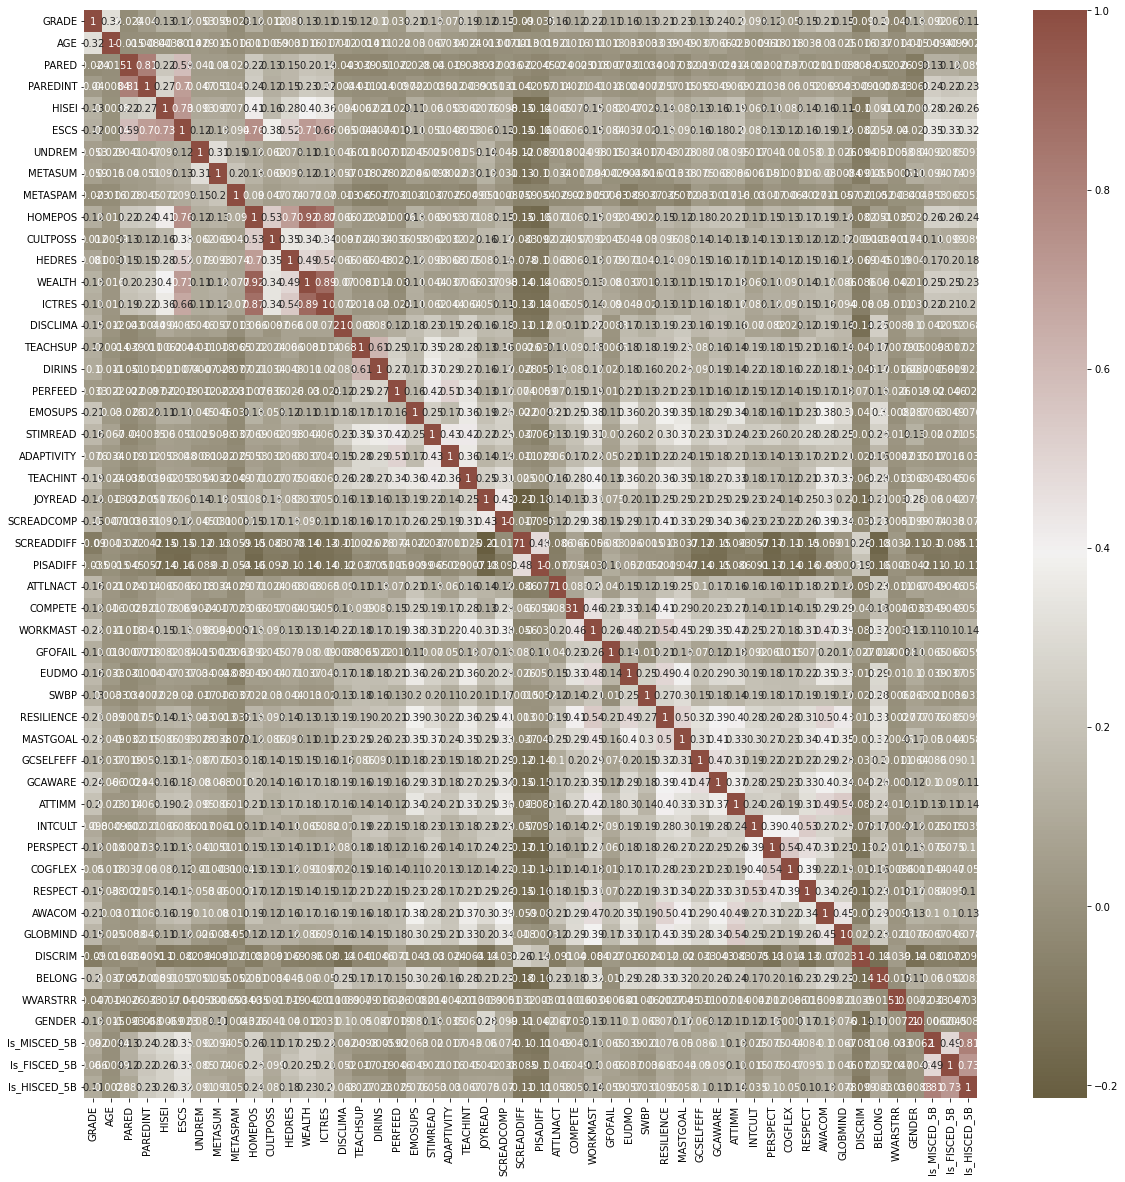

In [29]:
#Checking collinearity using correlation matrix
train_philippines_cormatrix = train_philippines.drop(columns= ['MATH','SCIENCE','READ','TOTALSCORE',], axis =1)
cmap = sns.diverging_palette(70,20,s=50, l=40, n=6,as_cmap=True)
corrmat= train_philippines_cormatrix.corr()
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corrmat,cmap=cmap,annot=True, )

In [32]:
# Drop columns with high correlation 
#Create correlation matrix
corr_matrix = train_philippines_cormatrix.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find features with correlation greater than 0.80
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]
print(f' Features to drop : {to_drop}')

 Features to drop : ['PAREDINT', 'WEALTH', 'ICTRES', 'Is_HISCED_5B']


In [33]:
# Drop features with high correlation among themselves
train_philippines.drop(to_drop, axis=1, inplace=True)
test_philippines.drop(to_drop, axis=1, inplace=True)
train_philippines.shape, test_philippines.shape

((4999, 53), (1447, 53))

## Exploring target variables

In [34]:
train_philippines[['MATH','READ', 'SCIENCE','TOTALSCORE']].describe().round(2)

MATH     READ  SCIENCE  TOTALSCORE
count  4999.00  4999.00  4999.00     4999.00
mean    357.03   344.98   360.97      354.33
std      72.81    77.93    71.27       71.69
min     109.13   133.68   167.43      142.59
25%     306.57   285.50   309.27      301.07
50%     352.75   330.48   348.93      343.13
75%     404.64   393.79   402.90      398.16
max     628.82   655.32   639.20      628.71

<Figure size 432x432 with 0 Axes>

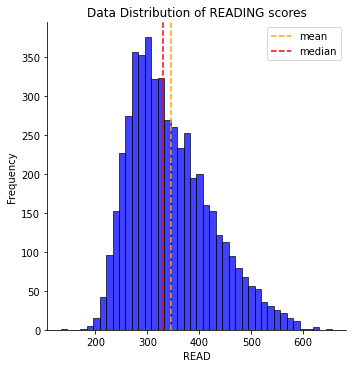

In [35]:
#Check data distribution of READING scores
plt.figure(figsize=(6,6))

sns.displot(train_philippines['READ'], color='b')

plt.ylabel('Frequency')

plt.title('Data Distribution of READING scores')

plt.axvline(train_philippines['READ'].mean(), linestyle = '--', color = 'orange', label ='mean')

plt.axvline(train_philippines['READ'].median(), linestyle = '--', color = 'r', label ='median')

plt.legend();


<Figure size 432x432 with 0 Axes>

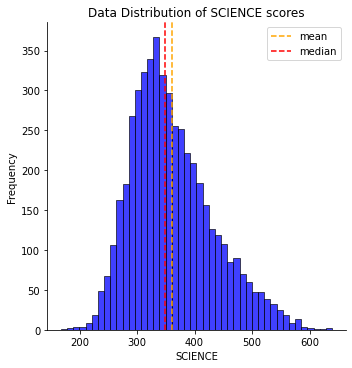

In [36]:
#Check data distribution of SCIENCE scores
plt.figure(figsize=(6,6))

sns.displot(train_philippines['SCIENCE'], color='b')

plt.ylabel('Frequency')

plt.title('Data Distribution of SCIENCE scores')

plt.axvline(train_philippines['SCIENCE'].mean(), linestyle = '--', color = 'orange', label ='mean')

plt.axvline(train_philippines['SCIENCE'].median(), linestyle = '--', color = 'r', label ='median')

plt.legend();

<Figure size 432x432 with 0 Axes>

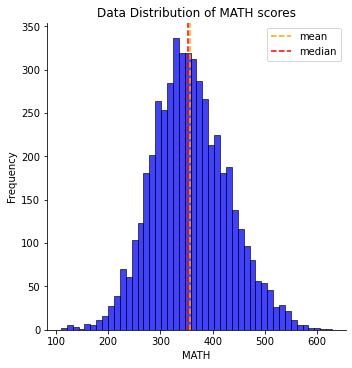

In [37]:
#Check data distribution of MATH scores
plt.figure(figsize=(6,6))

sns.displot(train_philippines['MATH'], color='b')

plt.ylabel('Frequency')

plt.title('Data Distribution of MATH scores')

plt.axvline(train_philippines['MATH'].mean(), linestyle = '--', color = 'orange', label ='mean')

plt.axvline(train_philippines['MATH'].median(), linestyle = '--', color = 'r', label ='median')

plt.legend();

<Figure size 432x432 with 0 Axes>

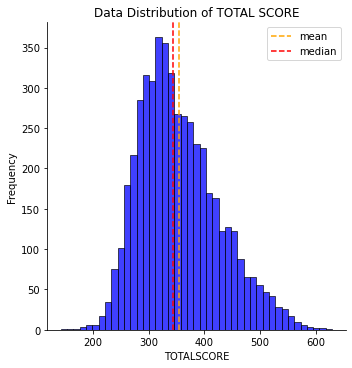

In [38]:
#Check data distribution of TOTALSCORE
plt.figure(figsize=(6,6))

sns.displot(train_philippines['TOTALSCORE'], color='b')

plt.ylabel('Frequency')

plt.title('Data Distribution of TOTAL SCORE')

plt.axvline(train_philippines['TOTALSCORE'].mean(), linestyle = '--', color = 'orange', label ='mean')

plt.axvline(train_philippines['TOTALSCORE'].median(), linestyle = '--', color = 'r', label ='median')

plt.legend();

All 'MATH','READ', 'SCIENCE', and 'TOTALSCORE' scores are slightly left skewed. Average score of SCIENCE is highest. In this study, TOTALSCORE will be the main target.

## Exploring correlations between features and the target variable

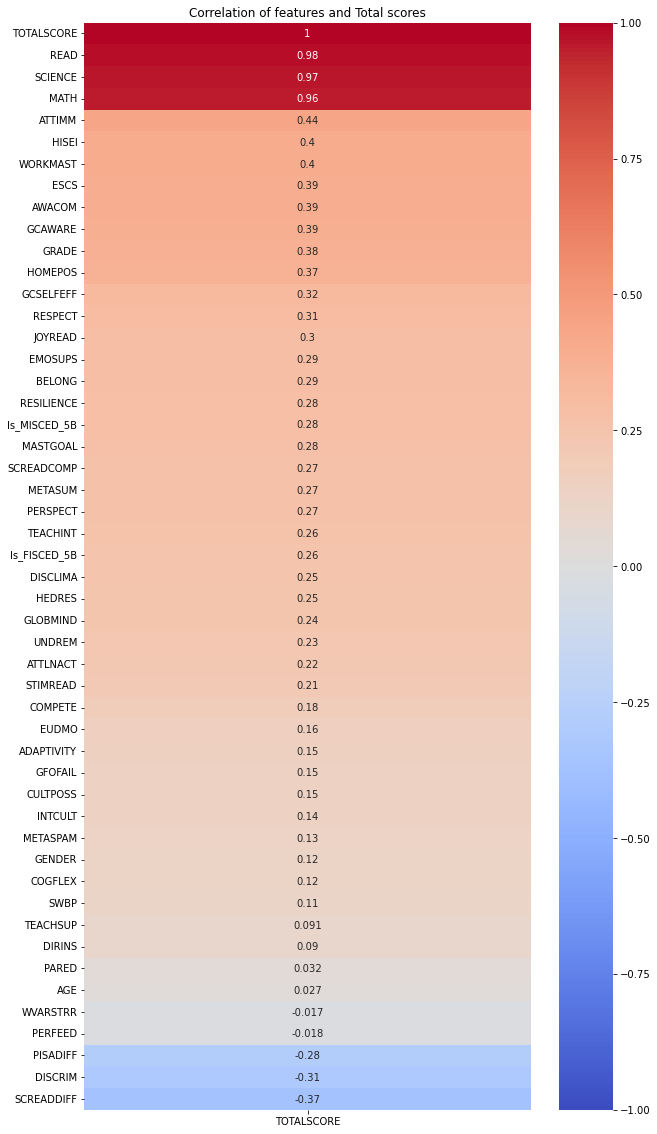

In [39]:
#Heatmap of correlation between features and TOTALSCORE
plt.figure(figsize = (10,20))
sns.heatmap(train_philippines.corr()[['TOTALSCORE']].sort_values(by = 'TOTALSCORE', ascending = False), 
                cmap = 'coolwarm',
                vmax = 1,
                vmin = -1,
                annot = True)
plt.title('Correlation of features and Total scores')

plt.yticks(rotation =0)
plt.show()

Due to too many features in building a model in this dataset, and the aim of this study is to explore features that impact PISA score. Thus, only features whcih have higher correlation with the target variable will be used in the models.

In [41]:
#Select features which have correlation above 0.18 or below -0.18 
selectd_features = (train_philippines.corr()[['TOTALSCORE']] > 0.25) | (train_philippines.corr()[['TOTALSCORE']] < -0.25)
selectd_features[selectd_features['TOTALSCORE']==True].index.values

array(['GRADE', 'HISEI', 'ESCS', 'METASUM', 'HOMEPOS', 'DISCLIMA',
       'EMOSUPS', 'TEACHINT', 'JOYREAD', 'SCREADCOMP', 'SCREADDIFF',
       'PISADIFF', 'WORKMAST', 'RESILIENCE', 'MASTGOAL', 'GCSELFEFF',
       'GCAWARE', 'ATTIMM', 'PERSPECT', 'RESPECT', 'AWACOM', 'DISCRIM',
       'BELONG', 'MATH', 'SCIENCE', 'READ', 'TOTALSCORE', 'Is_MISCED_5B',
       'Is_FISCED_5B'], dtype=object)

In [ ]:
#Save files for another study.
train_philippines.to_csv('train_pisa2018_philippines.csv')
test_philippines.to_csv('test_pisa2018_philippines.csv')

# Building Regressor Models

In [43]:
#Assemble our X and y variables
X_train =train_philippines[['GRADE', 'HISEI', 'ESCS', 'METASUM', 'HOMEPOS', 'DISCLIMA',
       'EMOSUPS', 'TEACHINT', 'JOYREAD', 'SCREADCOMP', 'SCREADDIFF',
       'PISADIFF', 'WORKMAST', 'RESILIENCE', 'MASTGOAL', 'GCSELFEFF',
       'GCAWARE', 'ATTIMM', 'PERSPECT', 'RESPECT', 'AWACOM', 'DISCRIM',
       'BELONG', 'Is_MISCED_5B', 'Is_FISCED_5B', 'ISCEDL', 'IMMIG', 'REPEAT', 'GENDER']]
X_train = pd.get_dummies(columns=[ 'Is_MISCED_5B', 'Is_FISCED_5B', 'ISCEDL', 'IMMIG', 'REPEAT', 'GENDER'], 
                         drop_first =True, data =X_train)
y_train = train_philippines['TOTALSCORE']

X_test =test_philippines[['GRADE', 'HISEI', 'ESCS', 'METASUM', 'HOMEPOS', 'DISCLIMA',
       'EMOSUPS', 'TEACHINT', 'JOYREAD', 'SCREADCOMP', 'SCREADDIFF',
       'PISADIFF', 'WORKMAST', 'RESILIENCE', 'MASTGOAL', 'GCSELFEFF',
       'GCAWARE', 'ATTIMM', 'PERSPECT', 'RESPECT', 'AWACOM', 'DISCRIM',
       'BELONG', 'Is_MISCED_5B', 'Is_FISCED_5B', 'ISCEDL', 'IMMIG', 'REPEAT', 'GENDER']]
X_test = pd.get_dummies(columns=[ 'Is_MISCED_5B', 'Is_FISCED_5B', 'ISCEDL', 'IMMIG', 'REPEAT', 'GENDER'], 
                         drop_first =True, data =X_test)
y_test = test_philippines['TOTALSCORE']

## Dummy Regressor model

In [44]:
from sklearn.dummy import DummyRegressor
baseline_model = DummyRegressor()
baseline_model.fit(X_train, y_train)
baseline_preds = baseline_model.predict(X_test)
# Test Score
baseline_model.score(X_test, y_test)
print(f'Test R-squared Score: {baseline_model.score(X_test, y_test)}')
#evaluate models with matrics
print(f'MSE is : {mean_squared_error(y_test, baseline_preds)}' )
print(f'RMSE is : {mean_squared_error(y_test, baseline_preds, squared = False)}' )

Test R-squared Score: -0.003735535960411651
MSE is : 4794.355657884172
RMSE is : 69.24128579022903


## Linear Regression model

In [45]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Train Score
lr.score(X_train, y_train)
print(f'Train R-squared Score: {lr.score(X_train, y_train)}')

# Test Score
lr.score(X_test, y_test)
print(f'Test R-squared Score: {lr.score(X_test, y_test)}')

# Cross Val Score
cross_val_score(lr, X_train, y_train, cv =5)
print(f' Cross Val Score :{cross_val_score(lr, X_train, y_train, cv =5)}')
print()
# Making prediction
y_preds = lr.predict(X_test)

#evaluate models with matrics
print(f'MSE is : {mean_squared_error(y_test, y_preds)}' )
print(f'RMSE is : {mean_squared_error(y_test, y_preds, squared = False)}' )

Train R-squared Score: 0.5928577864896041
Test R-squared Score: 0.5697677829285859
 Cross Val Score :[0.56631456 0.56463376 0.59650405 0.58599122 0.61905373]

MSE is : 2055.0097014815065
RMSE is : 45.3322148309732


In [46]:
lr.intercept_

330.81629863455106

In [47]:
pd.Series(lr.coef_, index = X_train.columns).sort_values(ascending=False)

ISCEDL_ISCED level 3        43.536641
IMMIG_Native                39.848697
IMMIG_Second-Generation     26.995433
ATTIMM                      13.778822
Is_MISCED_5B_1              12.645622
Is_FISCED_5B_1              12.074734
METASUM                     10.936709
GRADE                       10.754059
HOMEPOS                      7.890356
WORKMAST                     7.008658
AWACOM                       4.659063
GCAWARE                      4.525817
GCSELFEFF                    4.450273
DISCLIMA                     3.996444
JOYREAD                      3.549879
EMOSUPS                      2.448482
BELONG                       1.640145
TEACHINT                     1.589740
RESPECT                      0.882286
PERSPECT                     0.768564
SCREADCOMP                   0.614058
HISEI                        0.610059
MASTGOAL                    -1.200418
ESCS                        -2.996115
PISADIFF                    -3.025189
RESILIENCE                  -3.551574
GENDER_1    

#### Getting stadardized coefficients

In [48]:
scaler = StandardScaler()  #scaler object
X_train_sc = scaler.fit_transform(X_train)  #scaling training set
X_test_sc = scaler.transform(X_test)  #scaling test set

lr = LinearRegression()
lr.fit(X_train_sc, y_train)
y_preds = lr.predict(X_test_sc)

In [49]:
# coefficient dataframe
lr_coef = pd.DataFrame(data=[lr.coef_],columns=X_train.columns).T.sort_values(by=0,ascending=False)

# Label the color the each coefficient
color = ['red' if x < 0 else 'blue' for x in lr_coef[0]]

# Assign the color_list to new column
lr_coef['color'] = color

lr_coef.head()

0 color
HISEI    12.106264  blue
ATTIMM   10.862937  blue
METASUM   9.670330  blue
HOMEPOS   8.200999  blue
GRADE     8.192634  blue

In [50]:
# Select the highest values whether negative or positive
abs(lr_coef[0]).sort_values(ascending=False)[:10].index

Index(['HISEI', 'SCREADDIFF', 'DISCRIM', 'ATTIMM', 'REPEAT_Repeated a  grade',
       'METASUM', 'HOMEPOS', 'GRADE', 'WORKMAST', 'GCAWARE'],
      dtype='object')

Text(0.5, 1.0, 'Top 10 highest coefficient')

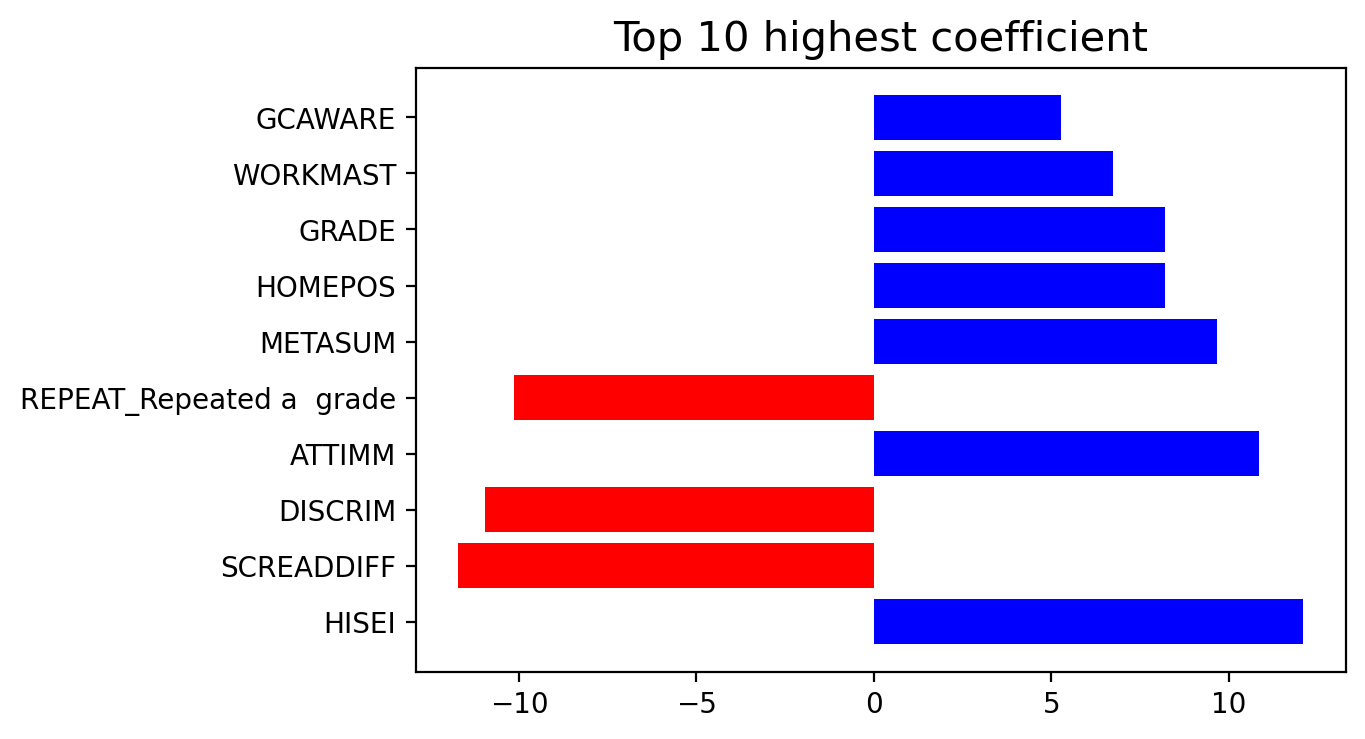

In [51]:
# Plot the coefficient of top 10 highest coefficient 
plt.figure(dpi=200)
plt.barh(lr_coef.loc[['HISEI', 'SCREADDIFF', 'DISCRIM', 'ATTIMM', 'REPEAT_Repeated a  grade',
       'METASUM', 'HOMEPOS', 'GRADE', 'WORKMAST', 'GCAWARE']].
         index,lr_coef.loc[['HISEI', 'SCREADDIFF', 'DISCRIM', 'ATTIMM', 'REPEAT_Repeated a  grade',
       'METASUM', 'HOMEPOS', 'GRADE', 'WORKMAST', 'GCAWARE']][0],
         color=lr_coef.loc[['HISEI', 'SCREADDIFF', 'DISCRIM', 'ATTIMM', 'REPEAT_Repeated a  grade',
       'METASUM', 'HOMEPOS', 'GRADE', 'WORKMAST', 'GCAWARE']]['color'])
plt.title('Top 10 highest coefficient',size=15)

## Random Forest Regressor

In [52]:
parameters = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [2,3,4]
}
regr = RandomForestRegressor(random_state=42)

clf = GridSearchCV(regr, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [2, 3, 4],
                         'n_estimators': [100, 150, 200, 250, 300]})

In [53]:
clf.best_params_

{'max_depth': 4, 'n_estimators': 100}

In [54]:
clf.score(X_train, y_train)

0.5749995401256252

In [55]:
clf.score(X_test, y_test)

0.5259647112566623

In [56]:
# Making prediction
y_preds_clf = clf.predict(X_test)

#evaluate models with matrics
print(f'RFReg MSE is : {mean_squared_error(y_test, y_preds_clf)}' )
print(f'RFReg RMSE is : {mean_squared_error(y_test, y_preds_clf, squared = False)}' )

RFReg MSE is : 2264.235634986042
RFReg RMSE is : 47.583985068361415


In [57]:
clf.best_estimator_

RandomForestRegressor(max_depth=4, random_state=42)

In [58]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score').head(5)[['params','param_max_depth','mean_test_score']]

params param_max_depth  mean_test_score
10  {'max_depth': 4, 'n_estimators': 100}               4         0.541091
11  {'max_depth': 4, 'n_estimators': 150}               4         0.540342
12  {'max_depth': 4, 'n_estimators': 200}               4         0.540227
14  {'max_depth': 4, 'n_estimators': 300}               4         0.540042
13  {'max_depth': 4, 'n_estimators': 250}               4         0.539882

## Support Vector Mechine: SVM

In [59]:
#Building SVM model need standardized data
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)

X_test_sc = scaler.transform(X_test)

#SVM
SVM = svm.SVR().fit(X_train_sc, y_train)
# Train Score
SVM.score(X_train_sc, y_train)
print(f'SVM Train R-squared Score: {SVM.score(X_train_sc, y_train)}')
print()

# Test Score
SVM.score(X_test_sc, y_test)
print(f'SVM Test R-squared Score: {SVM.score(X_test_sc, y_test)}')

# Cross Val Score
cross_val_score(SVM, X_train_sc, y_train, cv =5)
print(f'SVM Cross Val Score :{cross_val_score(SVM, X_train_sc, y_train, cv =5)}')
print()
# Making prediction
y_preds = SVM.predict(X_test_sc)

#evaluate SVMs with matrics
print(f'SVM MSE is : {mean_squared_error(y_test, y_preds)}' )
print(f'SVM RMSE is : {mean_squared_error(y_test, y_preds, squared = False)}' )

SVM Train R-squared Score: 0.5140544296653586

SVM Test R-squared Score: 0.5155596537661209
SVM Cross Val Score :[0.47633633 0.46759879 0.47548385 0.50772289 0.48050069]

SVM MSE is : 2313.935525508156
SVM RMSE is : 48.10338372202268


## XGboost regression model

In [60]:
xgb1 = XGBRegressor()
parameters = {'max_depth': [2,3,4,5],
              'subsample': [0.7, 1.0],
              'colsample_bytree': [0.7, 1.0],
              'n_estimators': [300, 500, 700]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
0.6639206741922008
{'colsample_bytree': 0.7, 'max_depth': 2, 'n_estimators': 300, 'subsample': 1.0}


In [61]:
pd.DataFrame(xgb_grid.cv_results_).sort_values('rank_test_score').head(5)[['params','param_max_depth','mean_test_score']]

params param_max_depth  \
1   {'colsample_bytree': 0.7, 'max_depth': 2, 'n_e...               2   
25  {'colsample_bytree': 1.0, 'max_depth': 2, 'n_e...               2   
3   {'colsample_bytree': 0.7, 'max_depth': 2, 'n_e...               2   
0   {'colsample_bytree': 0.7, 'max_depth': 2, 'n_e...               2   
27  {'colsample_bytree': 1.0, 'max_depth': 2, 'n_e...               2   

    mean_test_score  
1          0.663921  
25         0.660677  
3          0.660407  
0          0.657554  
27         0.657286

In [62]:
#XGRegressor
XGReg2 = xg.XGBRegressor(colsample_bytree = 0.7, max_depth = 2, n_estimators = 300, subsample = 1).fit(X_train, y_train) 
# Train Score
XGReg2.score(X_train, y_train)
print(f'XGReg2 Train R-squared Score: {XGReg2.score(X_train, y_train)}')
print()

# Test Score
XGReg2.score(X_test, y_test)
print(f'XGReg2 Test R-squared Score: {XGReg2.score(X_test, y_test)}')

# Cross Val Score
cross_val_score(XGReg2, X_train, y_train, cv =5)
print(f'XGReg2 Cross Val Score :{cross_val_score(XGReg2, X_train, y_train, cv =5)}')
print()
# Making prediction
y_preds = XGReg2.predict(X_test)

#evaluate models with matrics
print(f'XGReg2 MSE is : {mean_squared_error(y_test, y_preds)}' )
print(f'XGReg2 RMSE is : {mean_squared_error(y_test, y_preds, squared = False)}')

XGReg2 Train R-squared Score: 0.7917348143584134

XGReg2 Test R-squared Score: 0.6681331712954839
XGReg2 Cross Val Score :[0.66408279 0.66582949 0.66798891 0.66613696 0.68968182]

XGReg2 MSE is : 1585.1661626597308
XGReg2 RMSE is : 39.81414525843461


Because XGB regressor performance is highest among the blackbox models, we will see how each features perform or explain the target varible using SHAP

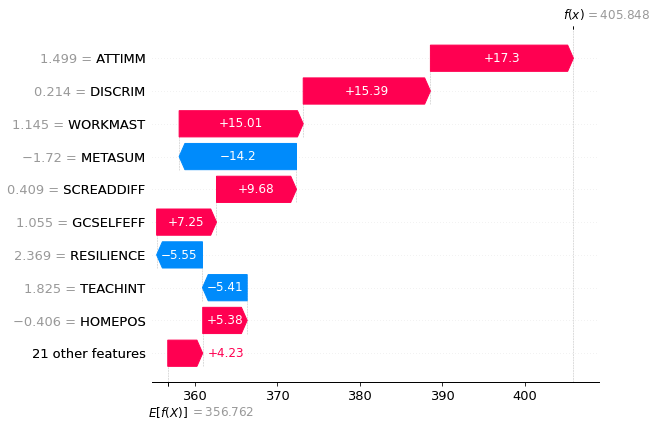

In [63]:
#Explain the model's predictions using SHAP
explainer = shap.Explainer(XGReg2, X_train)
shap_values = explainer(X_train)
shap.plots.waterfall(shap_values[100])

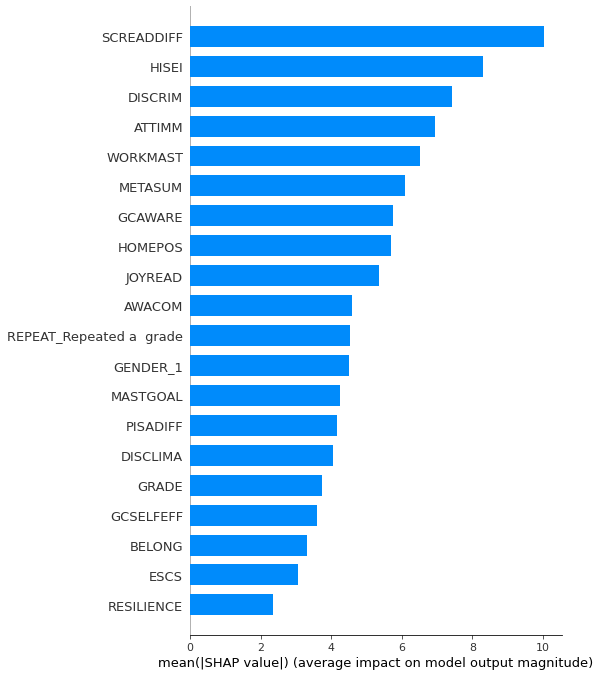

In [64]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

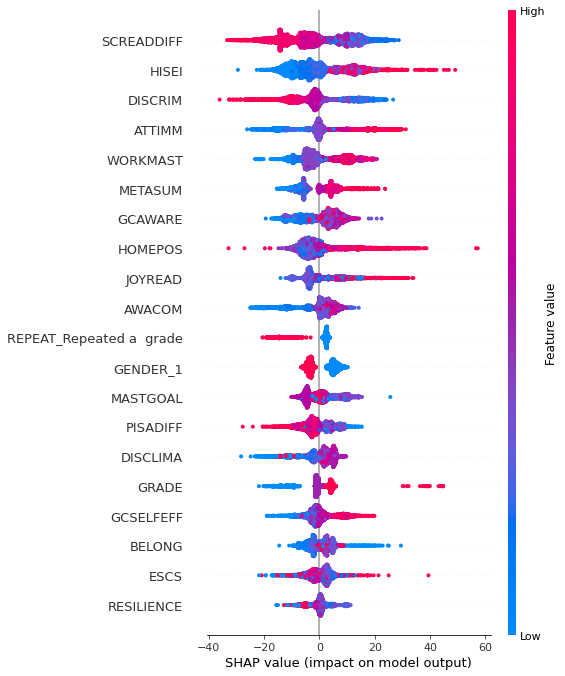

In [65]:
shap.summary_plot(shap_values, X_train)

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
Attempting to set identical bottom == top == 354.3269348144531 results in singular transformations; automatically expanding.
Attempting to set identical bottom == top == 354.3269348144531 results in singular transformations; automatically expanding.


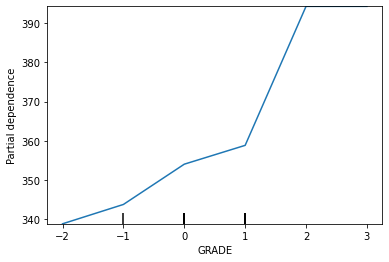

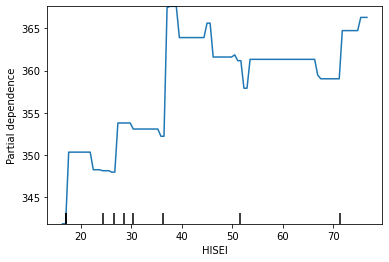

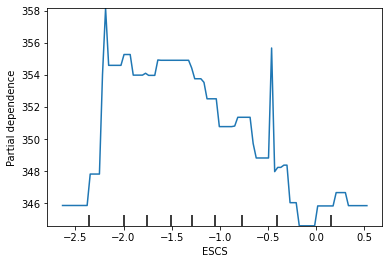

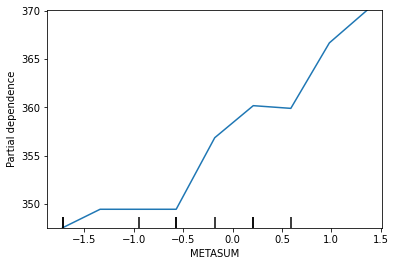

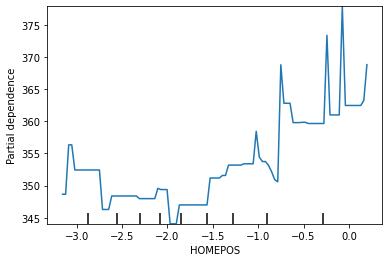

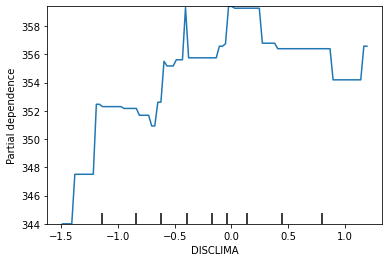

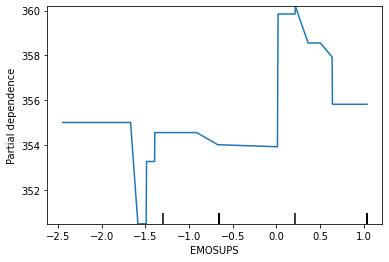

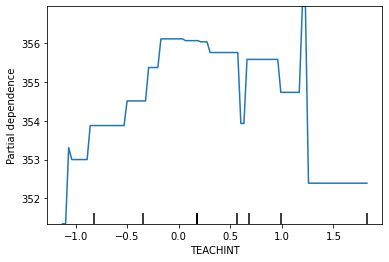

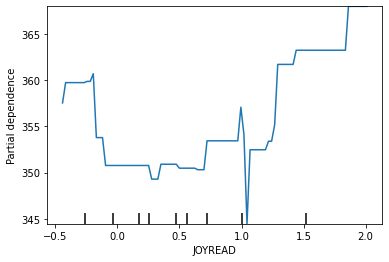

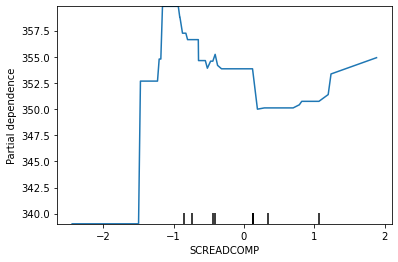

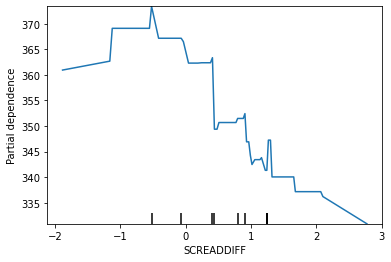

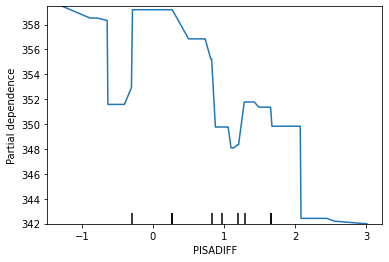

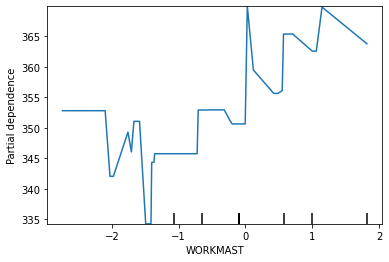

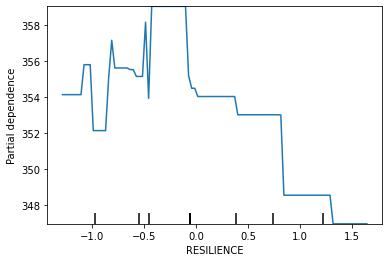

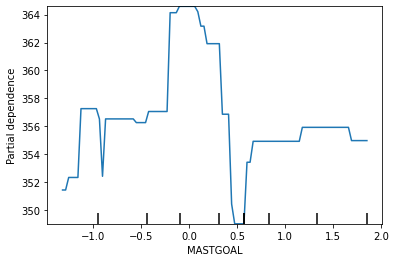

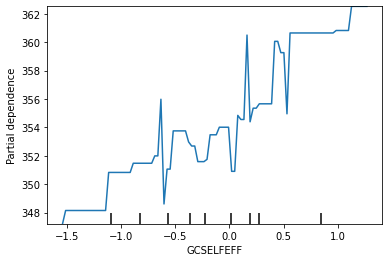

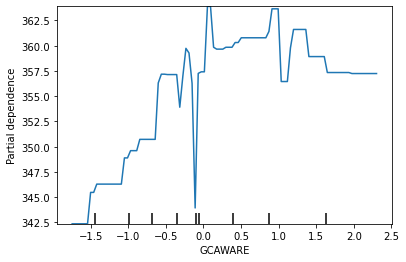

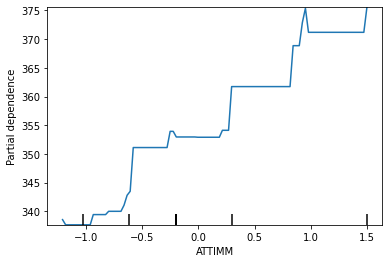

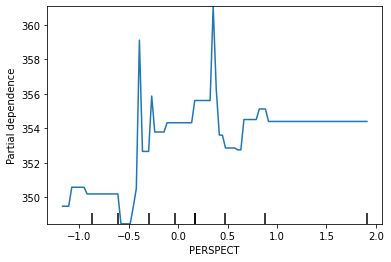

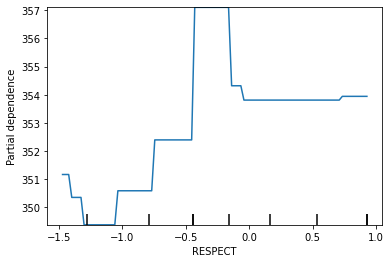

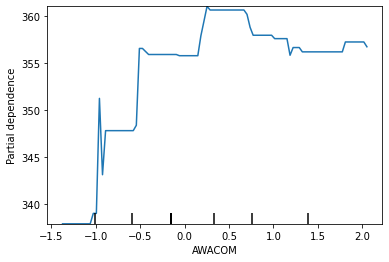

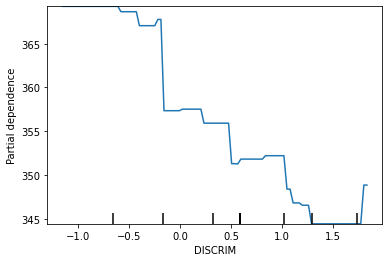

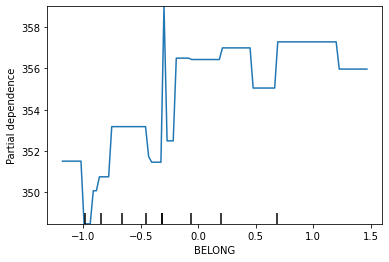

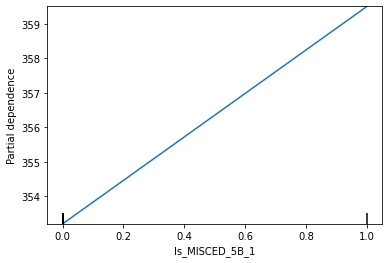

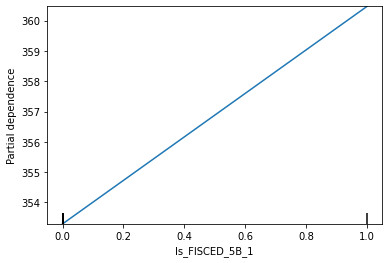

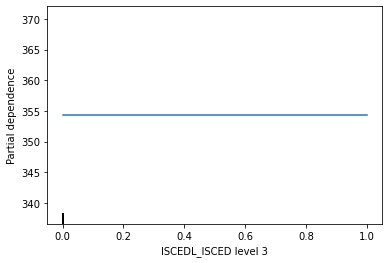

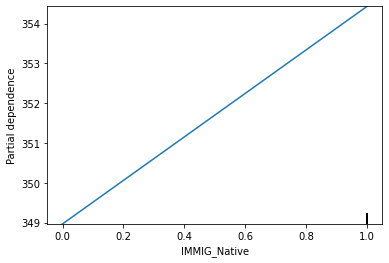

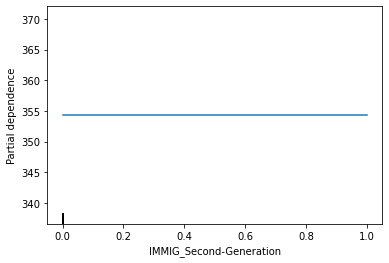

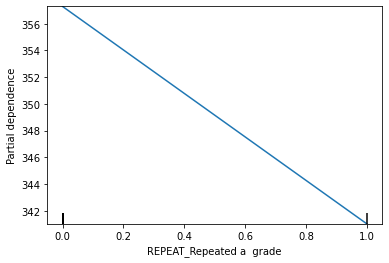

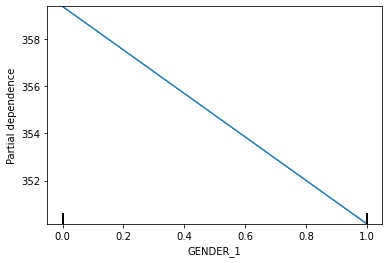

In [66]:
#Generate Partial Dependence Plot
from sklearn.inspection import PartialDependenceDisplay
for cols_name in X_train.columns:
    PartialDependenceDisplay.from_estimator(XGReg2, X_train, [cols_name]);

## Explainable Boosting Regressor

In [67]:
#import interpretml 
from interpret import show
from interpret.data import Marginal
from interpret.glassbox import ExplainableBoostingRegressor
from interpret.perf import RegressionPerf

In [68]:
ebm = ExplainableBoostingRegressor(random_state=42, n_jobs=-1, feature_names = X_train.columns)
ebm.fit(X_train, y_train) 

ExplainableBoostingRegressor(feature_names=['GRADE', 'HISEI', 'ESCS', 'METASUM',
                                            'HOMEPOS', 'DISCLIMA', 'EMOSUPS',
                                            'TEACHINT', 'JOYREAD', 'SCREADCOMP',
                                            'SCREADDIFF', 'PISADIFF',
                                            'WORKMAST', 'RESILIENCE',
                                            'MASTGOAL', 'GCSELFEFF', 'GCAWARE',
                                            'ATTIMM', 'PERSPECT', 'RESPECT',
                                            'AWACOM', 'DISCRIM', 'BELONG',
                                            'Is_MISCED_5B_1', 'Is_FISCED_5B_1',
                                            'ISCEDL_ISCED level 3',
                                            'IMMIG_Native'...
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'categorical',
                                            'categorical', 'categorical',
                                            'categorical', 'categorical',
                                            'categorical', 'categorical', ...],
                             n_jobs=-1)

In [69]:
import warnings
warnings.filterwarnings("ignore")
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)

<!-- http://127.0.0.1:7113/1928404146016/ -->

In [70]:
ebm_perf = RegressionPerf(ebm.predict).explain_perf(X_test, y_test, name='EBM')
show(ebm_perf)

<!-- http://127.0.0.1:7113/1928402020096/ -->